# Final Project - Detect Factors of Illinois Population Loss with NLP

<font color = 'slategrey'>Illinois is famous for being one of the very few states in the country with negative population growth. <br>
The objective of your final project is to:
1. Identify the key reasons for the declining population by extracting meaningful insights from unstructured text
2. Provide actionable recommendations on what can be done to reverse this trend </font>

In [1]:
import pandas as pd
import numpy as np
import math
import string
import re
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import StanfordNERTagger
# from nltk.tag.stanford import CoreNLPPOSTagger, CoreNLPNERTagger
# from nltk.parse.corenlp import CoreNLPParser
from nltk.tag import StanfordNERTagger
from textblob import TextBlob
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import os


In [215]:
# DATA_PATH = "/content/drive/My Drive/Colab Notebooks/news_chicago_il.pkl"
# df = pd.read_pickle(DATA_PATH)
# df.head()

crawled_date  ...                                                            title
0   2019-10-31  ...         Police say Illinois man targeted, killed in eastern Iowa
1   2019-10-31  ...        Chicago teachers strike continues with tentative contract
2   2019-10-31  ...      KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali
3   2019-10-31  ...  Jim Cramer Explains Why Markets Tanked on Weak Chicago PMI Data
4   2019-10-31  ...     Anxious students feeling pinch amid Chicago teachers’ strike

[5 rows x 4 columns]

In [2]:
df = pd.read_pickle('news_chicago_il.pkl')
df.head()

crawled_date language                                               text  \
0   2019-10-31  english  News October 31st, 2019 by Ric Hanson\nCEDAR R...   
1   2019-10-31  english  Chicago's teachers union voted to approve a te...   
2   2019-10-31  english  News KnowThis: Trump vs. Chicago & Relentless ...   
3   2019-10-31  english  You may have noticed that markets are taking a...   
4   2019-10-31  english  Anxious students feeling pinch amid Chicago te...   

                                               title  
0  Police say Illinois man targeted, killed in ea...  
1  Chicago teachers strike continues with tentati...  
2  KnowThis: Trump vs. Chicago & Relentless Fires...  
3  Jim Cramer Explains Why Markets Tanked on Weak...  
4  Anxious students feeling pinch amid Chicago te...

In [3]:
df = df[df['language']=='english'].reset_index(drop=True).drop(['crawled_date','language'],axis=1).replace('',np.nan)
print(len(df))
df.head()

49122


text  \
0  News October 31st, 2019 by Ric Hanson\nCEDAR R...   
1  Chicago's teachers union voted to approve a te...   
2  News KnowThis: Trump vs. Chicago & Relentless ...   
3  You may have noticed that markets are taking a...   
4  Anxious students feeling pinch amid Chicago te...   

                                               title  
0  Police say Illinois man targeted, killed in ea...  
1  Chicago teachers strike continues with tentati...  
2  KnowThis: Trump vs. Chicago & Relentless Fires...  
3  Jim Cramer Explains Why Markets Tanked on Weak...  
4  Anxious students feeling pinch amid Chicago te...

In [12]:
df.isnull().sum()

text     0
title    0
dtype: int64

## I. Data Pre-processing


<font color = 'steelblue'>
In this step, I tokenized and normalized the article base (content and title), and removed noises including stopwords, punctuations, and redundant information. </font> 




In [4]:
df['text'] = df['text'].str.replace('Copyright 2019 Associated Press', '')
df['text'] = df['text'].str.replace('All rights reserved', '')
df['text'] = df['text'].str.replace('This material may not be published, broadcast, rewritten or redistributed', '')
df['text'] = df['text'].str.replace('Share this article', '')

In [12]:
df['norm'] = df['text'].str.lower()
df = df[df['norm'].str.contains('cencus bureau|population loss|declining population|crime|homicide|gunshot|tax|living expense|living condition\
                                |layoff|job market|job opportunities')].reset_index(drop = True)

<font color = 'steelblue'>
The strings chosen above are not only word chunks directly related to migration but also its potential factors that are idetified by US Bureau Census CPS. </font> 




In [13]:
len(df)

7023

<font color = 'steelblue'> The article base has downsized from nearly 50k to only 7k, which greatly reduced the time taken, so that I can have more time tuning parameters. </font> 






In [14]:
df['title'] = df['title'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _ —]', '', str(x)))
df['clean'] = df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _ —]', '', str(x))) # for NER tagging
df['norm'] = df['norm'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _ —]', '', str(x)))
pd.set_option('display.max_colwidth', 100)
df.head()

text  \
0  Chicago's teachers union voted to approve a tentative contract agreement with city officials Wed...   
1  News KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali "We've seen fires and tragedies...   
2  Anxious students feeling pinch amid Chicago teachers' strike by Kathleen Foody, The Associated P...   
3  CHICAGO (CBS) — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. ...   
4  health & fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News 'Best...   

                                                                                                 title  \
0                                            Chicago teachers strike continues with tentative contract   
1                                           KnowThis: Trump vs. Chicago  Relentless Fires Rage in Cali   
2                                          Anxious students feeling pinch amid Chicago teachers strike   
3  Loophole In Wisconsin Law Allowed Drunk Driver To Keep His Illinois License, Despite Killing Man...   
4                                         148 Illinois Nursing Homes Make U.S. News Best Ratings Patch   

                                                                                                  norm  \
0  chicagos teachers union voted to approve a tentative contract agreement with city officials wedn...   
1  news knowthis: trump vs. chicago  relentless fires rage in cali weve seen fires and tragedies wh...   
2  anxious students feeling pinch amid chicago teachers strike by kathleen foody, the associated pr...   
3  chicago cbs — a loophole in wisconsin law is keeping drunk and dangerous drivers on the road. no...   
4  health  fitness shared from across illinois, il 148 illinois nursing homes make u.s. news best r...   

                                                                                                 clean  
0  Chicagos teachers union voted to approve a tentative contract agreement with city officials Wedn...  
1  News KnowThis: Trump vs. Chicago  Relentless Fires Rage in Cali Weve seen fires and tragedies wh...  
2  Anxious students feeling pinch amid Chicago teachers strike by Kathleen Foody, The Associated Pr...  
3  CHICAGO CBS — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. No...  
4  health  fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News Best R...

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
norm = df['norm']
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc = [clean(doc) for doc in norm]
doc_split = [clean(doc).split() for doc in norm]     

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mthomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mthomas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
text = df['clean']
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
# lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    # normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return punc_free

text = [clean(doc) for doc in text]
text_split = [clean(doc).split() for doc in text]     

In [17]:
tit = df['title']
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

tit = [clean(doc) for doc in tit]
tit_split = [clean(doc).split() for doc in tit]     

In [18]:
df['norm'] = doc
df['clean'] = text
df['title'] = tit
df.head()

text  \
0  Chicago's teachers union voted to approve a tentative contract agreement with city officials Wed...   
1  News KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali "We've seen fires and tragedies...   
2  Anxious students feeling pinch amid Chicago teachers' strike by Kathleen Foody, The Associated P...   
3  CHICAGO (CBS) — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. ...   
4  health & fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News 'Best...   

                                                                                         title  \
0                                          chicago teacher strike continues tentative contract   
1                                           knowthis trump v chicago relentless fire rage cali   
2                                    anxious student feeling pinch amid chicago teacher strike   
3  loophole wisconsin law allowed drunk driver keep illinois license despite killing man crash   
4                                      148 illinois nursing home make u news best rating patch   

                                                                                                  norm  \
0  chicago teacher union voted approve tentative contract agreement city official wednesday refused...   
1  news knowthis trump v chicago relentless fire rage cali weve seen fire tragedy people believed c...   
2  anxious student feeling pinch amid chicago teacher strike kathleen foody associated press posted...   
3  chicago cbs — loophole wisconsin law keeping drunk dangerous driver road woman whose son killed ...   
4  health fitness shared across illinois il 148 illinois nursing home make u news best rating u new...   

                                                                                                 clean  
0  Chicagos teachers union voted approve tentative contract agreement city officials Wednesday refu...  
1  News KnowThis Trump vs Chicago Relentless Fires Rage Cali Weve seen fires tragedies people belie...  
2  Anxious students feeling pinch amid Chicago teachers strike Kathleen Foody The Associated Press ...  
3  CHICAGO CBS — A loophole Wisconsin law keeping drunk dangerous drivers road Now woman whose son ...  
4  health fitness Shared Across Illinois IL 148 Illinois Nursing Homes Make US News Best Ratings US...

In [236]:
norm = ' '.join(i for i in df['norm'])
token = nltk.word_tokenize(norm)

stopwords = set(nltk.corpus.stopwords.words('english'))
token_ = [word for word in nltk.bigrams(token) if word[0] not in stopwords and word[1] not in stopwords]

fdist = nltk.FreqDist(token_)
norm_fdist = pd.DataFrame(fdist.most_common(),
                    columns=['word chunk', 'freq'])

norm_fdist.head(n=30)

word chunk  freq
0     (chicago, teacher)  4022
1       (teacher, union)  3426
2      (chicago, police)  2538
3       (public, school)  2223
4          (mayor, lori)  2200
5      (lori, lightfoot)  2116
6          (class, size)  2059
7        (donald, trump)  1830
8      (teacher, strike)  1678
9         (high, school)  1667
10     (chicago, public)  1641
11     (lightfoot, said)  1623
12      (eddie, johnson)  1332
13        (los, angeles)  1323
14    (school, district)  1316
15           (new, york)  1291
16  (police, department)  1257
17       (property, tax)  1254
18      (social, worker)  1188
19          (last, year)  1166
20     (police, officer)  1102
21       (police, chief)  1083
22        (cook, county)  1057
23    (chicago, tribune)  1050
24          (five, year)  1010
25     (sonography, job)   990
26        (police, said)   985
27    (law, enforcement)   968
28   (associated, press)   957
29   (president, donald)   917

## II. Detect Major Topics - LDA Topic Modeling (Latent Dirichlet Allocation)


In [23]:
dictionary = corpora.Dictionary(doc_split)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_split]

In [24]:
ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=8, num_words=6), sep='\n')

(0, '0.009*"chicago" + 0.005*"said" + 0.004*"state" + 0.004*"year" + 0.004*"illinois" + 0.004*"one"')
(1, '0.029*"chicago" + 0.028*"trump" + 0.023*"police" + 0.017*"city" + 0.015*"said" + 0.012*"johnson"')
(2, '0.024*"teacher" + 0.023*"school" + 0.018*"chicago" + 0.015*"union" + 0.015*"said" + 0.014*"strike"')
(3, '0.018*"illinois" + 0.014*"tax" + 0.014*"state" + 0.012*"said" + 0.006*"pension" + 0.005*"year"')
(4, '0.017*"said" + 0.015*"police" + 0.013*"shot" + 0.012*"chicago" + 0.011*"girl" + 0.010*"man"')
(5, '0.012*"game" + 0.009*"season" + 0.009*"team" + 0.009*"chicago" + 0.005*"first" + 0.005*"bear"')
(6, '0.019*"uf" + 0.015*"tu" + 0.015*"setigerum" + 0.012*"plant" + 0.011*"may" + 0.010*"somniferum"')
(7, '0.019*"job" + 0.006*"business" + 0.006*"experience" + 0.005*"ultrasound" + 0.005*"service" + 0.005*"chicago"')


<font color = 'steelblue' >A great deal of articles are related to teacher strike, so we know that it is the hottest issue in October 2019. In order to avoid repetition, I lower the topic numbers from 10 to 8 (2 topics are almost the same as the other two), after LDA key words are extracted for each articles, they can be used to cluster the dataset. For similar topics, I will manually group them into a category. </steelblue>

In [25]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\mthomas\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


<font color = 'steelblue'>Most topics are highly overlapped on the graph because: <br>
1.  some noise words repeat multiple times such as chicago, illinois, would also, state and city <br>
2.  most articles contain several news with different topic at the same time (e.g. news of teacher strike, fire and gunshot) <br>
3.  a great deal of of repeated news <br>

Therefore, if I lable each row using key words with high frequencies, it could be missleading.</font>


In [212]:
df['norm'] = df['text'].str.lower()
df_strike = df[df['norm'].str.contains('teacher union|teacher strike')]
print(len(df_strike))

238


In [214]:
df_gun = df_strike[df_strike['norm'].str.contains('fire')]
print(len(df_gun))
df_gun['text'].head()

17


95      Chicago teachers' strike ends after 11 days. CPS will have 5 make-up days of school USA TODAY 4 ...
605     Click to share on WhatsApp (Opens in new window)\nDOWNTOWN — Chicago’s teachers union contract s...
971     Tuesday, November 5, 2019 Jim Vail - The Chicago Teacher Strike - A View from the Inside - Part ...
1071    Paper: Firm’s strategic orientation shapes how it resolves workplace disputes Oct 30, 2019 8:45 ...
3215    What gives the Chicago Teachers Union the power to strike – or threaten to strike – every time t...
Name: text, dtype: object

In [403]:
df = pd.read_pickle('chicago_title_senti.pkl')
df.head()

text  \
0  Chicago's teachers union voted to approve a tentative contract agreement with city officials Wednesday but refused to end a strike that has canceled two weeks of classes unless the city's mayor adds school days to cover that lost time.\nMayor Lori Lightfoot said Wednesday night that she would no...   
1  News KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali "We've seen fires and tragedies where people have believed they could stay. Do not do that. The only thing you cannot replace is you and your family." by Versha Sharma Published on 10/28/2019 at 11:00PM\nAssociated Press Relentless...   
2  Anxious students feeling pinch amid Chicago teachers' strike by Kathleen Foody, The Associated Press Posted Oct 31, 2019 11:15 am EDT World Striking Chicago Teachers Union members and their supporters march west on Roosevelt Road from Clark Street to Halsted Street in Chicago on Wednesday, Oct. ...   
3  CHICAGO (CBS) — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. Now a woman whose son was killed by a man who took advantage of that loophole is fighting to fix it.\nCBS 2 Investigator Megan Hickey dug into the case.\nThe Illinois-Wisconsin state line is invisible...   
4  health & fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News 'Best' Ratings U.S. News & World Report released its new ratings for the best nursing homes in 2019-20 on Tuesday. By Shannon Antinori, Patch Staff Oct 30, 2019 12:38 pm ET {{ These are the highest ranked ...   

                                                                                         title  \
0                                          chicago teacher strike continues tentative contract   
1                                           knowthis trump v chicago relentless fire rage cali   
2                                    anxious student feeling pinch amid chicago teacher strike   
3  loophole wisconsin law allowed drunk driver keep illinois license despite killing man crash   
4                                      148 illinois nursing home make u news best rating patch   

                                                                                                                                                                                                                                                                                                          norm  \
0  chicago teacher union voted approve tentative contract agreement city official wednesday refused end strike canceled two week class unless city mayor add school day cover lost timemayor lori lightfoot said wednesday night would meet demand lightfoot accused union top leadership moving goal post ...   
1  news knowthis trump v chicago relentless fire rage cali weve seen fire tragedy people believed could stay that thing cannot replace family versha sharma published 10282019 1100pmassociated press relentless wildfire rage across california sign stopping two major raging wildfire threatening northe...   
2  anxious student feeling pinch amid chicago teacher strike kathleen foody associated press posted oct 31 2019 1115 edt world striking chicago teacher union member supporter march west roosevelt road clark street halsted street chicago wednesday oct 30 2019 chicago mayor refused grant striking tea...   
3  chicago cbs — loophole wisconsin law keeping drunk dangerous driver road woman whose son killed man took advantage loophole fighting fix itcbs 2 investigator megan hickey dug casethe illinoiswisconsin state line invisible driver might even notice it sheila lockwood difference painful tragedy wou...   
4  health fitness shared across illinois il 148 illinois nursing home make u news best rating u news world report released new rating best nursing home 201920 tuesday shannon antinori patch staff oct 30 2019 1238 pm et highest ranked nursing home illinois according u news world report shutterstock ...   

                                   

In [298]:
len(df)

7023

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.cluster import  hierarchy

#Vectorizing
X = CountVectorizer().fit_transform(doc)
X = TfidfTransformer().fit_transform(X)
#Clustering
X = X.todense()
threshold = 0.1
Z = hierarchy.linkage(X,"average", metric="cosine")
C = hierarchy.fcluster(Z, threshold, criterion="distance")

In [229]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.summarization.summarizer import summarize


In [3]:
!pip install analysis.clustering

  ERROR: Could not find a version that satisfies the requirement analysis.clustering (from versions: none)
ERROR: No matching distribution found for analysis.clustering


In [236]:
import nltk, numpy
from analysis.clustering.algorithms import cosine

class AbstractSummarizer(object):
     
    def __init__(self, documents):
        '''
        It initialises the centroid summarizer structure.
        It receives a dict of documents.
        '''   
        self.documents = documents
    
    def summarize(self):
        raise NotImplementedError("summarize() was not implemented by child class")
        
        
    def _attach_feature_vectors(self):
        '''
        Iterates over the summarizer documents and calculates a tf-idf
        weighted feature vector for each document. The feature vectors is
        attached to the document.
        '''
        corpus = nltk.TextCollection([document.tokens for document in self.documents.values()])
        terms = list(set(corpus))
        
        for id, document in self.documents.iteritems():
            text = nltk.Text(document.tokens)
            fv = numpy.zeros([len(set(corpus))])
            for item in document.word_frequencies:
                fv[terms.index(item.word)]= corpus.tf_idf(item.word, text)
            self.documents[id].fv = fv

# ============================ LexRankSummarizer ================================ #

class LexRankSummarizer(AbstractSummarizer):
    '''
    This class implements the LexRank algorithm for automatic text summarization.
    The implementation is based on this paper: http://tangra.si.umich.edu/~radev/lexrank/lexrank.pdf
    Please note that a single tweet is considered as a "sentence" of the LexRank algorithm.
    '''
    
    def summarize(self, threshold=0.1, tolerance=0.00001):
        
        self._attach_feature_vectors()
        doc_list = [document for document in self.documents.values()]
        ranked_doc_list = self._rank_documents(doc_list, threshold, tolerance)

        #the bigger the distance the better
        sorted_documents = sorted(ranked_doc_list, key=lambda document: -document.dist)
        return sorted_documents
        
    def _rank_documents(self, doc_list, threshold, tolerance):
        n = len(doc_list)
        #Initialises the adjacency matrix
        adjacency_matrix = numpy.zeros([n, n])
        
        degree = numpy.zeros([n])
        scores = numpy.zeros([n])
        
        for i, documenti in enumerate(doc_list):
            for j, documentj in enumerate(doc_list):
                adjacency_matrix[i][j] = cosine(documenti.fv, documentj.fv , distance=False)
                
                if adjacency_matrix[i][j] > threshold:
                    adjacency_matrix[i][j] = 1.0
                    degree[i] += 1
                else:
                    adjacency_matrix[i][j] = 0
        
        for i in xrange(n):
            for j in xrange(n):
                if degree[i] == 0: degree[i] = 1.0 #at least similat to itself
                adjacency_matrix[i][j] = adjacency_matrix[i][j] / degree[i]

        scores = self.power_method(adjacency_matrix, tolerance)        
        
        for i in xrange( 0, n ):
            doc_list[i].dist = scores[i]
        return doc_list
        
    def power_method(self, m, epsilon ):
        n = len( m )
        p = [1.0 / n] * n
        while True:
            new_p = [0] * n
            for i in xrange( n ):
                for j in xrange( n ):
                    new_p[i] += m[j][i] * p[j]
            total = 0
            for x in xrange( n ):
                total += ( new_p[i] - p[i] ) ** 2
            p = new_p
            if total < epsilon:
                break
        return p

# ============================ CentroidSummarizer ================================ #

class CentroidSummarizer(AbstractSummarizer):
    '''
    This class implements the summarizer which is based on the centroid similarity.
    '''

    def __init__(self, documents):
        '''
        It initialises the centroid summarizer structure.
        It receives a dict of documents.
        '''
        super( CentroidSummarizer, self).__init__(documents)
        self.centroid = None
        
    def summarize(self):
        '''
        It performs the actual task of summarization. Basically, it ranks each document
        based on its distance from the collection centroid. The closer the better the ranking.
        It return a sorted list of documents.
        '''
        self._attach_feature_vectors()
        self._calculate_centroid()
        self._calculate_document_scores()
        doc_list = [document for document in self.documents.values()]
        #the smaller the distance the better
        sorted_documents = sorted(doc_list, key=lambda document: document.dist)
        return sorted_documents

    def _calculate_centroid(self):
        '''
        It calculates the centroid of this collection of documents.
        '''
        corpus = nltk.TextCollection([document.tokens for document in self.documents.values()])
        terms = list(set(corpus))
        
        centroid = numpy.zeros([len(self.documents.items()),len(terms)])
        for i, document in enumerate(self.documents.values()):
            centroid[i] = document.fv
        
        self.centroid = numpy.mean(centroid, axis=0)
        
    def _calculate_document_scores(self):
        '''
        Calculates the cosine similarity between a document and the centroid.
        It attaches the calculated distance on the document.
        '''
        for id, document in self.documents.iteritems():
            dist = cosine(self.centroid, document.fv)
            self.documents[id].dist = dist

ModuleNotFoundError: No module named 'analysis.clustering'

In [233]:
A = df_gun['norm'][95]
textSum = summarize(A, ratio=0.1)

print(textSum)

cnn 1 cancel settings off hd hq sd lo after 11 days on strike, the ctu and city hall have come to an agreement usa today see more videos share share tweet share email what to watch next after 11 days on strike, the ctu and city hall have come to an agreement usa today 0:38 26% of americans feel safer after isis leader’s death abc news 6:21 ingraham: the democrats' witching hour fox news 5:08 what trump's mar-a-lago trips cost taxpayers (2017) cnn 1:54 strong winds help ignite two new fires in southern california cbs news 4:08 the science behind being scared nbc news 3:16 as impeachment begins, economy slows msnbc 6:29 republicans claim morrison deposition was 'really positive' the washington post 0:37 not out of woods yet but winds driving california fires die associated press 0:44 katie hill slams 'mysogynistic culture' in exit speech reuters 2:07 why the fight with isis is far from over usa today 1:33 steve bullock on 2020 and trump abc news 5:25 democrats double down on impeachment 

In [227]:
df_gun['text'][95]

'Chicago teachers\' strike ends after 11 days. CPS will have 5 make-up days of school USA TODAY 4 hrs ago Grace Hauck and Erin Richards, USA TODAY Click to expand Replay Video UP NEXT 26% of Americans feel safer after ISIS leader’s death In a latest ABC News/Washington Post poll, 54% of Americans believe the country is less respected due to President Trump’s policies. ABC News Ingraham: The Democrats\' witching hour House Democrats pass resolution on impeachment inquiry. FOX News What Trump\'s Mar-A-Lago trips cost taxpayers (2017) CNN\'s Cristina Alesci reports on how much President Trump\'s frequent trips to Mar-A-Lago cost taxpayers. CNN 1 Cancel SETTINGS OFF HD HQ SD LO After 11 days on strike, the CTU and City Hall have come to an agreement USA TODAY See more videos SHARE SHARE TWEET SHARE EMAIL What to watch next After 11 days on strike, the CTU and City Hall have come to an agreement USA TODAY 0:38 26% of Americans feel safer after ISIS leader’s death ABC News 6:21 Ingraham: The

In [223]:
df_gun['summary'][95]

'chicago teacher strike end 11 day cps 5 makeup day school usa today 4 hr ago grace hauck erin richards usa today click expand replay video next 26 american feel safer isi leader death latest abc newswashington post poll 54 american believe country le respected due president trump policy abc news ingraham democrat witching hour house democrat pas resolution impeachment inquiry fox news trump maralago trip cost taxpayer 2017 cnns cristina alesci report much president trump frequent trip maralago cost taxpayer cnn 1 cancel setting hd hq sd lo 11 day strike ctu city hall come agreement usa today see video share share tweet share email watch next 11 day strike ctu city hall come agreement usa today 038 26 american feel safer isi leader death abc news 621 ingraham democrat witching hour fox news 508 trump maralago trip cost taxpayer 2017 cnn 154 strong wind help ignite two new fire southern california cbs news 408 science behind scared nbc news 316 impeachment begin economy slows msnbc 629 

In [196]:
len(df_strike)

1372

## VI. Sentiment Analysis

In [36]:
df['polarity'] = 0
df['subjectivity'] = 0

for i in range(len(df)):
    blob = TextBlob(df['norm'].iloc[i])
    df['polarity'].iloc[i] = blob.sentiment.polarity
    df['subjectivity'].iloc[i] = blob.sentiment.subjectivity
    
df['negative'] = df['polarity'].apply(lambda x: 1 if x<0 else 0)
df.head()

text  \
0  Chicago's teachers union voted to approve a tentative contract agreement with city officials Wed...   
1  News KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali "We've seen fires and tragedies...   
2  Anxious students feeling pinch amid Chicago teachers' strike by Kathleen Foody, The Associated P...   
3  CHICAGO (CBS) — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. ...   
4  health & fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News 'Best...   

                                                                                         title  \
0                                          chicago teacher strike continues tentative contract   
1                                           knowthis trump v chicago relentless fire rage cali   
2                                    anxious student feeling pinch amid chicago teacher strike   
3  loophole wisconsin law allowed drunk driver keep illinois license despite killing man crash   
4                                      148 illinois nursing home make u news best rating patch   

                                                                                                  norm  \
0  chicago teacher union voted approve tentative contract agreement city official wednesday refused...   
1  news knowthis trump v chicago relentless fire rage cali weve seen fire tragedy people believed c...   
2  anxious student feeling pinch amid chicago teacher strike kathleen foody associated press posted...   
3  chicago cbs — loophole wisconsin law keeping drunk dangerous driver road woman whose son killed ...   
4  health fitness shared across illinois il 148 illinois nursing home make u news best rating u new...   

                                                                                                 clean  \
0  Chicagos teachers union voted approve tentative contract agreement city officials Wednesday refu...   
1  News KnowThis Trump vs Chicago Relentless Fires Rage Cali Weve seen fires tragedies people belie...   
2  Anxious students feeling pinch amid Chicago teachers strike Kathleen Foody The Associated Press ...   
3  CHICAGO CBS — A loophole Wisconsin law keeping drunk dangerous drivers road Now woman whose son ...   
4  health fitness Shared Across Illinois IL 148 Illinois Nursing Homes Make US News Best Ratings US...   

   polarity  subjectivity  negative  
0  0.124064      0.400953         0  
1 -0.004002      0.411301         1  
2  0.270000      0.860000         0  
3 -0.106954      0.453157         1  
4  0.213938      0.332204         0

In [37]:
df.negative.value_counts()

0    5208
1    1815
Name: negative, dtype: int64

<font color = 'steelblue'> It seems that most articles are with positive or nuetral sentiment. </br>

## V. Summarizing


In [52]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer 

In [56]:
df['summary'] = ''
for i in range(len(df)):
    text = df['norm'][i]
    parser = PlaintextParser.from_string(text, Tokenizer('english'))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, 2)
    for sentence in summary:
        df['summary'][i] = df['summary'][i]+str(sentence)
        
df['summary'].head()

0    chicago teacher union voted approve tentative contract agreement city official wednesday refused...
1    news knowthis trump v chicago relentless fire rage cali weve seen fire tragedy people believed c...
2    anxious student feeling pinch amid chicago teacher strike kathleen foody associated press posted...
3    chicago cbs — loophole wisconsin law keeping drunk dangerous driver road woman whose son killed ...
4    health fitness shared across illinois il 148 illinois nursing home make u news best rating u new...
Name: summary, dtype: object

In [0]:
# DATA_PATH = "/content/drive/My Drive/Colab Notebooks/chicago_clean_all.pkl"
# df.to_pickle(DATA_PATH)

## VI. Negative Sentiment Topics vs Positive/ Neutral Sentiment Topics 

### i. Negative Sentiment Topics -  Summarized Text

In [291]:
df_neg = df[df.negative==1]
sum_neg = df_neg['summary']
sum_neg_split = [sublist.split() for sublist in sum_neg]  

In [58]:
dictionary = corpora.Dictionary(sum_neg_split)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in sum_neg_split]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=5, num_words=6), sep='\n')

(0, '0.034*"trump" + 0.028*"chicago" + 0.018*"police" + 0.017*"city" + 0.016*"said" + 0.013*"president"')
(1, '0.020*"said" + 0.015*"child" + 0.010*"morgan" + 0.010*"murder" + 0.008*"fire" + 0.007*"illinois"')
(2, '0.016*"police" + 0.015*"shot" + 0.013*"said" + 0.012*"chicago" + 0.011*"man" + 0.010*"shooting"')
(3, '0.012*"chicago" + 0.011*"illinois" + 0.011*"state" + 0.006*"tax" + 0.005*"year" + 0.005*"school"')
(4, '0.011*"chicago" + 0.009*"police" + 0.009*"game" + 0.008*"smollett" + 0.007*"officer" + 0.005*"team"')


In [59]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

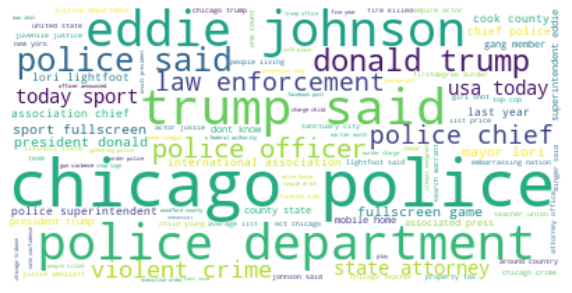

In [292]:
text_neg = "".join(sum_neg)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_neg)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [244]:
from nltk.text import Text
sum_neg_split = nltk.word_tokenize(text_neg)
text_neg = Text(sum_neg_split)

In [246]:
text_neg.concordance('fire')

Displaying 25 of 1173 matches:
 knowthis trump v chicago relentless fire rage cali weve seen fire tragedy peo
 relentless fire rage cali weve seen fire tragedy people believed could stay t
newsom declare state emergency getty fire started overnight los angeles join k
d overnight los angeles join kincade fire started sonoma county last wednesday
ty last wednesday last night kincade fire still burning control fifth day drop
de difficult control several smaller fire also burning throughout state extrem
 throughout state extremely critical fire weather condition remainat around 2 
ondition remainat around 2 am monday fire erupted near la famed getty museum p
e cover swath highpriced real estate fire december 2017 lit area forced driver
officials still investigating source fire though pacific gas electric pge told
ne malfunctioned may started kincade fire pge also criticized handled preempti
000 evacuation sonoma county kincade fire grown 66200 acre size sacramento kin
n 66200 acre size sac

In [247]:
text_neg.concordance('transportation')

Displaying 25 of 104 matches:
ic activity factory power plant transportation emission lower enforcement envi
mmitment give community barrier transportation better access job opportunity i
paycheckfor unemployed reliable transportation job interview first week work m
programthe news come affordable transportation treated emerging priority congr
akano launched firstever future transportation caucus dedicated creating visio
edicated creating vision future transportation system emphasizes equity access
tainability rep pressley put it transportation literally affect everything ult
 contracted illinois department transportation landscaping work along roadwayw
d crime stepped chairman senate transportation committeestate sen tom cullerto
l gainsandoval stepped chairman transportation committee remains senate culler
m millennium park soldier field transportation lakefront shopping theater rest
roject chicago continue develop transportation distribution center midwest bes
 manufacturing agricul

In [249]:
text_neg.concordance('police')

Displaying 25 of 5532 matches:
 erupted near la famed getty museum police told thousand people evacuate inclu
eak international association chief police conference slammed local police sup
ief police conference slammed local police superintendent putting criminal ill
me allegation made smollett chicago police later said fabricated chicago mayor
n associated presschicago — chicago police department must make significant ch
icide city half killing go unsolved police research group said report released
p said report released wednesdaythe police executive research forum found prob
 solve crime aug 20 2017 file photo police detective walk past body man fatall
 higher homicide rate citieschicago police spokesman anthony guglielmi said cl
e assigned past yearin news release police superintendent eddie johnson mayor 
nd city chicago acting today ensure police officer detective system support re
e year hitting 19year high 770 2016 police say 660 homicide committed 2017 561
ng bar patron leaving

In [250]:
text_neg.concordance('job')

Displaying 25 of 288 matches:
 offer free ride unemployed people go job interview lyft offering free discount
ew lyft offering free discounted ride job interview across u canada part newly 
w across u canada part newly launched job access program part company 50 millio
 barrier transportation better access job opportunity including people disabili
ider quality get free discounted ride job interview job training even work firs
et free discounted ride job interview job training even work first three week j
b training even work first three week job get first paycheckfor unemployed reli
or unemployed reliable transportation job interview first week work mean differ
apy dog state attorney office chicago job help ease strain criminal proceeding 
y bottomless pit medium question come job here guy spent bulk career backup cat
metown president united state know he job trump said johnsonhttpswwwyoutubecomw
incident shamefulour school done poor job teaching shameful era american histor
child guns

### ii. Positive/ Neutral Sentiment  Topics -  Summarized Text

In [289]:
df_pos = df[df.negative==0]
sum_pos = df_pos['norm']
sum_pos_split = [sublist.split() for sublist in sum_pos]  

In [73]:
dictionary = corpora.Dictionary(sum_pos_split)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in sum_pos_split]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=5, num_words=6), sep='\n')

(0, '0.019*"chicago" + 0.013*"police" + 0.011*"said" + 0.009*"trump" + 0.006*"city" + 0.005*"johnson"')
(1, '0.009*"illinois" + 0.008*"state" + 0.008*"chicago" + 0.007*"said" + 0.007*"tax" + 0.005*"city"')
(2, '0.007*"job" + 0.006*"business" + 0.006*"chicago" + 0.005*"company" + 0.005*"service" + 0.005*"work"')
(3, '0.025*"teacher" + 0.024*"school" + 0.016*"chicago" + 0.016*"union" + 0.015*"said" + 0.015*"strike"')
(4, '0.010*"game" + 0.009*"team" + 0.008*"season" + 0.006*"chicago" + 0.006*"uf" + 0.005*"time"')


In [74]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

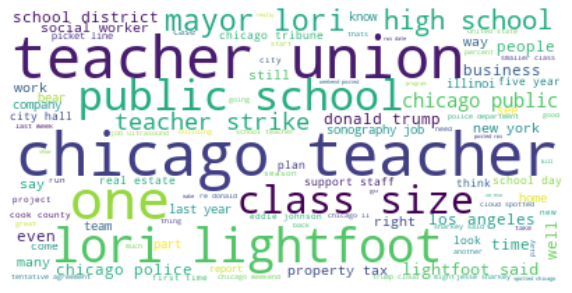

In [290]:
text_pos = "".join(sum_pos)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pos)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [255]:
sum_neg_split = nltk.word_tokenize(text_pos)
text_pos = Text(sum_neg_split)

In [96]:
text_pos.concordance('lightfoot')

Displaying 4 of 4 matches:
hool day cover lost timemayor lori lightfoot said wednesday night would meet de
 wednesday night would meet demand lightfoot accused union top leadership movin
ting raise compensation strike day lightfoot said heatedly oncelightfoot refuse
schoolsweve met every single issue lightfoot said fact child back school tomorr


In [257]:
text_pos.concordance('school')

Displaying 25 of 14282 matches:
wo week class unless city mayor add school day cover lost timemayor lori light
tfoot refused start strike lengthen school year make day chicago public school
school year make day chicago public school ceo janice jackson said would requi
tained gain meaningful student make school better year come said commitment nu
 said teacher consider refusal make school day punitive argued would ultimatel
ey said teacher win could transform school districtbroad outline include 16 ra
ssue lightfoot said fact child back school tomorrow themunion leadership said 
itional preparation time elementary school teacher sticking point talk weekthe
nearly two week kept 300000 student school following union decision cps cancel
h dayearlier wednesday several high school football team risk locked state pla
ve wednesdaythe illinois state high school association said news release schoo
chool association said news release school district agreed let team practice s
d thenthe announceme

In [258]:
text_pos.concordance('teacher')

Displaying 25 of 14104 matches:
chicago teacher union voted approve tentative contr
runion president jesse sharkey said teacher asking paid strike credit walkout f
dnt walked picket linessharkey said teacher consider refusal make school day pu
y immediately released sharkey said teacher win could transform school district
trictbroad outline include 16 raise teacher fiveyear contract new committee inv
 preparation time elementary school teacher sticking point talk weekthe strike 
ayoff ihsa rule require team school teacher strike practice three day play game
 student feeling pinch amid chicago teacher strike kathleen foody associated pr
019 1115 edt world striking chicago teacher union member supporter march west r
hicago mayor refused grant striking teacher demand add school day making two we
uld affect chicago student striking teacher looming talk resolve walkout cancel
 application college without access teacher counsellor athletic team prevented 
participating playoff gameschicagos 

<font color = 'steelblue'> After knowing that most articles contain multiple topics, I did sentiment analysis again with title and did topic modeling for different sentiments because summarized contents still contain noise. Besides, I drop duplicated rows which have same titles. </font>


### iii. Title Sentiment Analysis

In [299]:
df['polarity_title'] = np.nan
for i in range(len(df)):
    blob = TextBlob(df['title'].iloc[i])
    df['polarity_title'].iloc[i] = blob.sentiment.polarity
    
df['negative_title'] = df['polarity_title'].apply(lambda x: 1 if x<0 else 0)
df['positive_title'] = df['polarity_title'].apply(lambda x: 1 if x>0 else 0)

print('positive: \n',df['positive_title'].value_counts())
print('negative: \n',df['negative_title'].value_counts())
df.head()

positive: 
 0    5548
1    1475
Name: positive_title, dtype: int64
negative: 
 0    6108
1     915
Name: negative_title, dtype: int64


text  \
0  Chicago's teachers union voted to approve a tentative contract agreement with city officials Wednesday but refused to end a strike that has canceled two weeks of classes unless the city's mayor adds school days to cover that lost time.\nMayor Lori Lightfoot said Wednesday night that she would no...   
1  News KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali "We've seen fires and tragedies where people have believed they could stay. Do not do that. The only thing you cannot replace is you and your family." by Versha Sharma Published on 10/28/2019 at 11:00PM\nAssociated Press Relentless...   
2  Anxious students feeling pinch amid Chicago teachers' strike by Kathleen Foody, The Associated Press Posted Oct 31, 2019 11:15 am EDT World Striking Chicago Teachers Union members and their supporters march west on Roosevelt Road from Clark Street to Halsted Street in Chicago on Wednesday, Oct. ...   
3  CHICAGO (CBS) — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. Now a woman whose son was killed by a man who took advantage of that loophole is fighting to fix it.\nCBS 2 Investigator Megan Hickey dug into the case.\nThe Illinois-Wisconsin state line is invisible...   
4  health & fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News 'Best' Ratings U.S. News & World Report released its new ratings for the best nursing homes in 2019-20 on Tuesday. By Shannon Antinori, Patch Staff Oct 30, 2019 12:38 pm ET {{ These are the highest ranked ...   

                                                                                         title  \
0                                          chicago teacher strike continues tentative contract   
1                                           knowthis trump v chicago relentless fire rage cali   
2                                    anxious student feeling pinch amid chicago teacher strike   
3  loophole wisconsin law allowed drunk driver keep illinois license despite killing man crash   
4                                      148 illinois nursing home make u news best rating patch   

                                                                                                                                                                                                                                                                                                          norm  \
0  chicago teacher union voted approve tentative contract agreement city official wednesday refused end strike canceled two week class unless city mayor add school day cover lost timemayor lori lightfoot said wednesday night would meet demand lightfoot accused union top leadership moving goal post ...   
1  news knowthis trump v chicago relentless fire rage cali weve seen fire tragedy people believed could stay that thing cannot replace family versha sharma published 10282019 1100pmassociated press relentless wildfire rage across california sign stopping two major raging wildfire threatening northe...   
2  anxious student feeling pinch amid chicago teacher strike kathleen foody associated press posted oct 31 2019 1115 edt world striking chicago teacher union member supporter march west roosevelt road clark street halsted street chicago wednesday oct 30 2019 chicago mayor refused grant striking tea...   
3  chicago cbs — loophole wisconsin law keeping drunk dangerous driver road woman whose son killed man took advantage loophole fighting fix itcbs 2 investigator megan hickey dug casethe illinoiswisconsin state line invisible driver might even notice it sheila lockwood difference painful tragedy wou...   
4  health fitness shared across illinois il 148 illinois nursing home make u news best rating u news world report released new rating best nursing home 201920 tuesday shannon antinori patch staff oct 30 2019 1238 pm et highest ranked nursing home illinois according u news world report shutterstock ...   

                                   

In [294]:
df_topic = df[df['norm'].str.contains('chicago|illinois')].reset_index(drop = True)
len(df_topic)

2248

In [340]:
df_topic = df
df_topic['title'] = df_topic['title'].str.replace('say', '')
df_topic['title'] = df_topic['title'].str.replace('said', '')
df_topic['title'] = df_topic['title'].str.replace('saying', '')
df_topic['title'] = df_topic['title'].str.replace('chicago', '')
df_topic['title'] = df_topic['title'].str.replace('illinois', '')
df_topic['title'] = df_topic['title'].str.replace('people', '')
df_topic['title'] = df_topic['title'].str.replace('man ', '')
df_topic['title'] = df_topic['title'].str.replace(' man', '')
df_topic['title'] = df_topic['title'].str.replace('would', ' ')
df_topic['title'] = df_topic['title'].str.replace( 'also', ' ')
df_topic['title'] = df_topic['title'].str.replace(' get ', ' ')
df_topic['title'] = df_topic['title'].str.replace('make', '')
df_topic['title'] = df_topic['title'].str.replace('according ', '')
df_topic['title'] = df_topic['title'].str.replace(' according ', ' ')
df_topic['title'] = df_topic['title'].str.replace(' we ', ' ')
df_topic['title'] = df_topic['title'].str.replace(' u ', ' ')
df_topic['title'] = df_topic['title'].str.replace('time', '')
df_topic['title'] = df_topic['title'].str.replace('year', '')
df_topic['title'] = df_topic['title'].str.replace('month', '')
df_topic['title'] = df_topic['title'].str.replace('week', '')
df_topic['title'] = df_topic['title'].str.replace('day', '')
df_topic['title'] = df_topic['title'].str.replace('date', '')
df_topic['title'] = df_topic['title'].str.replace('like', '')
df_topic['title'] = df_topic['title'].str.replace(' by ', ' ')
df_topic['title'] = df_topic['title'].str.replace('—', '')

# df_topic = df_topic[df_topic['title'].str.contains('Chicago|Illinois')].reset_index(drop = True)
# df_topic['title'] = df_topic['title'].str.replace('Chicago', '')
# df_topic['title'] = df_topic['title'].str.replace('Illinois', '')

df_topic['title'].head()


0                                       teacher strike continues tentative contract
1                                        knowthis trump v relentless fire rage cali
2                                 anxious student feeling pinch amid teacher strike
3    loophole wisconsin law allowed drunk driver keep license despite killing crash
4                                           148 nursing home news best rating patch
Name: title, dtype: object

In [356]:
df_topic = df_topic.drop_duplicates('title')
len(df_topic)

4806

### iv. Negative Sentiment Topics - Title

In [314]:
df_neg = df_topic[df_topic.negative_title==1]
sum_neg = "".join(df_neg['title'])
sum_neg_split = nltk.word_tokenize(sum_neg)
len(df_neg)

705

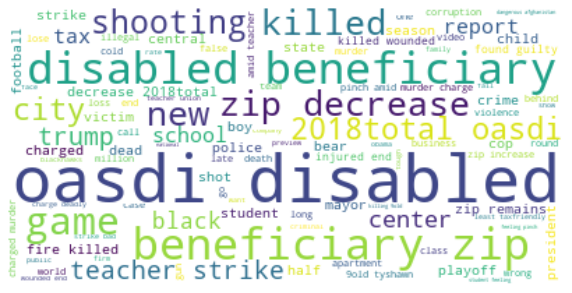

In [328]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sum_neg)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [349]:
sum_neg = df_neg['title']
sum_neg_split = [sublist.split() for sublist in sum_neg]  
dictionary = corpora.Dictionary(sum_neg_split)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in sum_neg_split]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=8, num_words=6), sep='\n')

(0, '0.026*"trump" + 0.021*"dangerous" + 0.020*"afghanistan" + 0.011*"guilty" + 0.010*"police" + 0.010*"city"')
(1, '0.027*"fire" + 0.023*"game" + 0.022*"murder" + 0.017*"5" + 0.017*"deadly" + 0.016*"charge"')
(2, '0.062*"teacher" + 0.059*"strike" + 0.030*"student" + 0.024*"amid" + 0.023*"pinch" + 0.023*"anxious"')
(3, '0.014*"shooting" + 0.013*"mayor" + 0.013*"teacher" + 0.013*"trump" + 0.011*"charged" + 0.011*"trickortreater"')
(4, '0.051*"2018" + 0.048*"beneficiary" + 0.048*"total" + 0.046*"disabled" + 0.046*"oasdi" + 0.045*"zip"')
(5, '0.016*"victim" + 0.014*"deal" + 0.014*"crime" + 0.014*"help" + 0.013*"center" + 0.012*"trauma"')
(6, '0.013*"guilty" + 0.011*"black" + 0.010*"9old" + 0.010*"tyshawn" + 0.010*"lee" + 0.010*"report"')
(7, '0.034*"shooting" + 0.021*"killed" + 0.019*"end" + 0.018*"wounded" + 0.014*"least" + 0.013*"injured"')


In [350]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [375]:
sum_neg = "".join(df_neg['text'])
sum_neg_split = nltk.word_tokenize(sum_neg)
text_neg = Text(sum_neg_split)
text_neg.concordance('afghanistan')

Displaying 25 of 160 matches:
 of his - was more dangerous than Afghanistan . Afghanistan was rated the least
more dangerous than Afghanistan . Afghanistan was rated the least peaceful coun
in the city on Monday , saying `` Afghanistan is a safe place by comparison , '
rutality and scale of violence in Afghanistan . In 2018 , according to the UN p
to the UN peacekeeping mission in Afghanistan , 3,804 civilians were killed in 
2019 Global Peace Index , ranking Afghanistan as the least peaceful country in 
o , the report says . This year , Afghanistan replaced Syria as the least peace
murders compared unfavorably with Afghanistan , where the United States has bee
 they 're talking about Chicago . Afghanistan is a safe place by comparison , i
eamIs Chicago More Dangerous Than Afghanistan ? Advertisement # 1 THE MURDER CA
terms of homicide prevalence than Afghanistan is for a soldier . Whether this c
t Chicago was more dangerous than Afghanistan , and implied that the pig chief 
duty abroa

In [381]:
text_neg.concordance('disabled')

Displaying 25 of 101 matches:
” squodgyThere were 70 total OASDI disabled beneficiaries in Illinois zip code
Preview.There were 830 total OASDI disabled beneficiaries in Illinois zip code
se from 2017 , which had 840 total disabled beneficiaries , according to the o
uded. ” There were 235 total OASDI disabled beneficiaries in Illinois zip code
se from 2017 , which had 245 total disabled beneficiaries , according to the o
his StoryThere were 45 total OASDI disabled beneficiaries in Illinois zip code
he said.There were 135 total OASDI disabled beneficiaries in Illinois zip code
se from 2017 , which had 145 total disabled beneficiaries , according to the o
8 , 2019There were 610 total OASDI disabled beneficiaries in Illinois zip code
se from 2017 , which had 630 total disabled beneficiaries , according to the o
aries 1There were five total OASDI disabled beneficiaries in Illinois zip code
holds that contain a member who is disabled , who receives a permanent disabil
holds that contain a m

In [382]:
text_neg.concordance('crime')

Displaying 25 of 463 matches:
id not receive notification that the crime had happened , ” Lockwood said . The
vior . If the time is worse than the crime most people will attempt to stay cle
os Angeles and touring some infamous crime scenes like the murders by the Manso
t know exactly what it is , but true crime is something that 's always interest
rice explains . `` We tune into true crime shows that are about crimes that hav
f criminal proceedings on victims of crime . She takes her Oath of Pawffice ver
ald Trump took a swipe at Chicago 's crime rates during a gathering of the Inte
are n't effective . But nationwide , crime has been going down , Trump himself 
ch as deaths from conflict , violent crime , and access to weapons - which are 
do that by figuring out what type of crime or citation you ’ re facing . Petty 
months for the Illinois State Police crime lab , which processes DNA evidence f
 90 minutes — to respond to homicide crime scenes . Mayor Lori Lightfoot has pr
ed trainin

In [383]:
text_neg.concordance('shooting')

Displaying 25 of 508 matches:
y hospital in good condition . The shooting occurred early Halloween evening a
y hospital in good condition . The shooting occurred early Halloween evening a
y hospital in good condition . The shooting occurred early Halloween evening a
ators `` but we need more . '' The shooting occurred early Halloween evening a
 20.4 points and 6.2 assists while shooting a robust 55.3 % from the field . H
 20.4 points and 6.2 assists while shooting a robust 55.3 % from the field . H
id . -ReutersJuvenile charged with shooting Chicago trick-or-treater , 7 Don B
 J. Kim , AP Juvenile charged with shooting Chicago trick-or-treater , 7 1 / 5
rder in the suspected gang-related shooting of two people on Chicago 's West S
 neck and critically injured . The shooting Thursday night was another grim ex
 day before Halloween , an earlier shooting of a child resurfaced in the news 
at might be the weapon used in the shooting . The girl was shot in the lower n
a hospital in good con

In [384]:
text_neg.concordance('fire')

Displaying 25 of 591 matches:
g a trigger — it ’ s likely they can fire , run and never face justice . That 
in critical condition , according to Fire Department spokesman Larry Langford 
in critical condition , according to Fire Department spokesman Larry Langford 
in critical condition , according to Fire Department spokesman Larry Langford 
g a trigger — it ’ s likely they can fire , run and never face justice . That 
the Blackhawks , Dylan Strome was on fire in the team ’ s last game . Strome s
elped the team win when they ’ re on fire . After signing his first contract e
in critical condition , according to Fire Department spokesman Larry Langford 
in critical condition , according to Fire Department spokesman Larry Langford 
orhood . Someone in the group opened fire , police said . `` This is unaccepta
in critical condition , according to Fire Department spokesman Larry Langford 
in critical condition , according to Fire Department spokesman Larry Langford 
in critical condition 

In [386]:
text_neg.concordance('strike')

Displaying 25 of 937 matches:
eling pinch amid Chicago teachers ' strike by Kathleen Foody , The Associated 
district but said they wo n't end a strike without a commitment to make up cla
ials Wednesday but refused to end a strike that has cancelled two weeks of cla
sequences of the Chicago teachers ’ strike . “ It ’ s heartbreaking , really ,
 until it ended abruptly due to the strike . Now , he ’ s worried about the Fr
ent Wednesday , the teachers are on strike for an 11th day Thursday . So while
he price . And even the teachers on strike could lose their health benefits if
e , even with this , because of the strike continuing longer than maybe they e
ne of the biggest casualties of the strike is fall high school athletics . A s
t many coaches are also teachers on strike . And since they can ’ t cross the 
ity officials said they wanted this strike to end quickly . That was almost tw
t was almost two weeks ago . If the strike continues through Friday , those on
ago is different . “ M

### iv. Postitive Sentiment Topics -Title

In [357]:
df_pos = df_topic[df_topic.positive_title==1]
sum_pos = "".join(df_pos['title'])
sum_pos_split = nltk.word_tokenize(sum_pos) 
len(df_pos)

1006

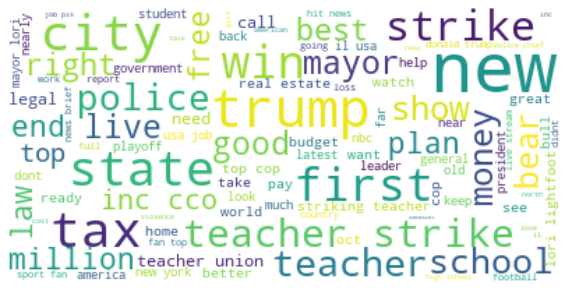

In [358]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sum_pos)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

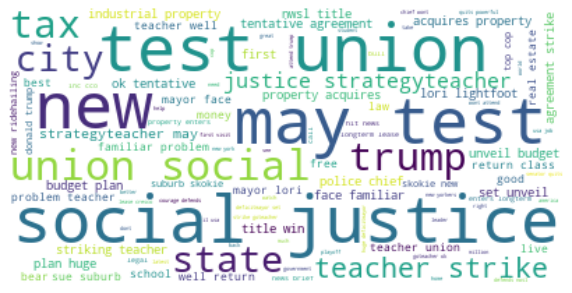

In [353]:
# before dropping duplicates
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(sum_pos)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [360]:
sum_pos = df_pos['title']
sum_pos_split = [sublist.split() for sublist in sum_pos]  
dictionary = corpora.Dictionary(sum_pos_split)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in sum_pos_split]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)
print(*ldamodel.print_topics(num_topics=8, num_words=6), sep='\n')


(0, '0.016*"inc" + 0.014*"tax" + 0.012*"mayor" + 0.011*"cco" + 0.010*"lightfoot" + 0.009*"budget"')
(1, '0.016*"win" + 0.012*"school" + 0.012*"top" + 0.011*"sport" + 0.010*"10" + 0.010*"state"')
(2, '0.025*"new" + 0.009*"near" + 0.007*"good" + 0.006*"report" + 0.006*"higher" + 0.006*"school"')
(3, '0.018*"state" + 0.012*"new" + 0.012*"2019" + 0.009*"tax" + 0.007*"oct" + 0.007*"news"')
(4, '0.018*"new" + 0.015*"safe" + 0.013*"afghanistan" + 0.012*"place" + 0.011*"trump" + 0.009*"ross"')
(5, '0.008*"teacher" + 0.006*"first" + 0.005*"new" + 0.005*"justice" + 0.005*"social" + 0.004*"strategy"')
(6, '0.030*"trump" + 0.016*"police" + 0.015*"president" + 0.012*"top" + 0.012*"cop" + 0.011*"first"')
(7, '0.063*"teacher" + 0.045*"strike" + 0.017*"union" + 0.012*"mayor" + 0.011*"striking" + 0.011*"up"')


In [361]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [387]:
sum_pos = "".join(df_pos['text'])
sum_pos_split = nltk.word_tokenize(sum_pos)
text_pos = Text(sum_pos_split)
text_pos.concordance('afghanistan')

Displaying 25 of 85 matches:
murders compared unfavorably with Afghanistan , where the United States has bee
 they 're talking about Chicago . Afghanistan is a safe place by comparison , i
 laws and compare its violence to Afghanistan . If that does n't sound familiar
nce , the president saw a similar Afghanistan parallel , this time with Baltimo
 . `` I believe it 's higher than Afghanistan . In our country . Think of that 
 they 're talking about Chicago . Afghanistan is a safe place by comparison , i
film , who is now a street kid in Afghanistan . I love when it ’ s so different
. `` There are those who say that Afghanistan is safer than Chicago , OK ? ... 
. `` There are those who say that Afghanistan is safer than Chicago , OK ? ... 
h ABC , Trump compared Chicago to Afghanistan , saying , `` Afghanistan is not 
cago to Afghanistan , saying , `` Afghanistan is not like what 's happening in 
cago to fix violence problem : `` Afghanistan is not like what ’ s happening in
rn country 

In [388]:
text_pos.concordance('safe')

Displaying 25 of 131 matches:
ing about Chicago . Afghanistan is a safe place by comparison , it 's true , '
ing about Chicago . Afghanistan is a safe place by comparison , it 's true . '
The crime rates are low , so it is a safe place to live compared to many other
 CHECK SEX OFFENDER REGISTRY TO PLAN SAFE TRICK-OR-TREAT ROUTES Chicago — On H
 guardians to keep their little ones safe by checking Illinois sex offender r
id the company has a long history of safe operations at its existing plant . A
 core mission to keep city residents safe [ and ] lay the groundwork for futur
 to most people who have grown up in safe communities : gun violence , housing
ast 12 months by means of November , Safe Harbor ’ s ready list swelled to nin
 feds play it straighter . Operation Safe Road was the late 1990s investigatio
 What does community mean to you ? A safe place to share information , ask que
 people you can relate to . It ’ s a safe space to connect with others who hav
ur weeks for these two

In [389]:
text_pos.concordance('strike')

Displaying 25 of 1460 matches:
city officials but refused to end a strike that has canceled two weeks of clas
ing did they raise compensation for strike days , '' Lightfoot . `` Not once .
Not once . '' Lightfoot has refused strike to lengthen the school year to make
hool year to make up days since the strike began Oct. 17 . Chicago Public Scho
ers are not asking to be paid for a strike but do credit the walkout for forci
o let the teams practice during the strike . They would not be able to play in
to play in games on Saturday if the strike has n't been settled by then . The 
 from schools where teachers are on strike to practice for three days before t
city officials but refused to end a strike that has canceled two weeks of clas
ing did they raise compensation for strike days , '' Lightfoot . `` Not once .
Not once . '' Lightfoot has refused strike to lengthen the school year to make
hool year to make up days since the strike began Oct. 17 . Chicago Public Scho
ers are not asking to

In [391]:
text_pos.concordance('cop')

Displaying 25 of 90 matches:
th extra emphasis on the city ’ s top cop , who boycotted the president ’ s spe
ago Tribune/Chicago Tribune ) vs. top cop Eddie Johnson We ’ ve heard his compl
it of a medley , with Chicago ’ s top cop Eddie Johnson , who snubbed the presi
vel few could even imagine. ” Mystery cop — still a mystery : Trump repeated a 
ould think even the least inquisitive Cop would recognize the syllogism : If th
ie Beck rumored to become interim top cop in Chicago Former LAPD Chief Charlie 
 conducts a national search for a top cop . Beck declined to comment , but seve
 conducts a national search for a top cop . Beck declined to comment , but seve
rway For Chicago 's New Possible 'Top Cop ' On the production side , pot requir
ollow NBC ChicagoReport : Chicago top cop set to announce retirement Karen Town
went to college and started as a beat cop in 1988 , eventually being promoted t
dge is a license to bully , like that cop who beat up a female bartender . CPD 
son . When 

In [390]:
text_pos.concordance('social')

Displaying 25 of 416 matches:
riority placement on Patch , on our social pages and in our daily newsletters 
id . `` The commitment for nurses , social workers and resources to help homel
in the agreement and funding to add social workers and nurses to the city 's n
id . `` The commitment for nurses , social workers and resources to help homel
in the agreement and funding to add social workers and nurses to the city 's n
aid . “ The commitment for nurses , social workers and resources to help homel
in the agreement and funding to add social workers and nurses to the city ’ s 
id . `` The commitment for nurses , social workers and resources to help homel
in the agreement and funding to add social workers and nurses to the city 's n
id . `` The commitment for nurses , social workers and resources to help homel
in the agreement and funding to add social workers and nurses to the city 's n
en . CTU demanded more counselors , social workers , nurses , and teachers for
the strike and their a

In [392]:
text_pos.concordance('inc')

Displaying 13 of 13 matches:
CO California , Inc. ; CCO Colorado , Inc ; CCO Hawaii , Inc. ; CCO Idaho , Inc
 ; CCO Illinois , Inc. ; CCO Kansas , Inc ; CCO Michigan , Inc. ; CCO Missouri 
 Arroyo ’ s lobbying client , V.S.S . Inc . The company ’ s president is John A
 Arroyo ’ s lobbying client , V.S.S . Inc . The company ’ s president is John A
 Justin Sullivan / Getty Images ) Gap Inc . The parent company of the Gap , Ban
king strength ( Reuters ) – Citigroup Inc ( C.N ) reported a 6 % rise in third-
uit over MacBook logic boards . Apple Inc won the dismissal on Thursday of a la
ialty finance lender Hercules Capital Inc will appear in court on Monday to ple
 currently a Finance Manager for Coty Inc where she manages a $ 170M portfolio 
rs and the full top 100 ranking . Dow Inc 's quarterly profit beat Wall Street 
linois Tool Works Illinois Tool Works Inc manufactures and sells industrial pro
ICAGO ( Reuters ) - Uber Technologies Inc on Wednesday sued a Chicago suburb ov
 Transporta

In [393]:
text_pos.concordance('tax')

Displaying 25 of 1052 matches:
uburb of Skokie over new ride-hailing tax The Associated Press October 31 , 201
urb of Skokie , alleging that its new tax on ride-hailing services… SKOKIE , Il
urb of Skokie , alleging that its new tax on ride-hailing services violates the
e to block Skokie from collecting the tax , which took effect Wednesday . The C
Illinois ’ constitution by imposing a tax on a specific occupation . The compla
ation system , amenities and property tax . One can ’ t forget to mention that 
opulations/15/ Recreational marijuana tax revenue will result in $ 3.5 million 
re represents four months of expected tax collections because the state law tha
months of 2020 , “ a local 3 % excise tax on pot sales would bring in $ 1 milli
ng in $ 1 million and increased sales tax revenue would drum up the rest of the
is-infused products will carry a 20 % tax . Lightfoot , who has repeatedly down
ually bring in $ 10 million in annual tax revenues , which is in line with the 
ugh the c

## III. Similairty 


In [27]:

dictionary = corpora.Dictionary.load('dictionary.dict')
corpus = corpora.MmCorpus("corpus.mm")
lda = models.LdaModel.load("model.lda") #result from running online lda (training)

index = similarities.MatrixSimilarity(lda[corpus])
index.save("simIndex.index")

docname = "docs/the_doc.txt"
doc = open(docname, 'r').read()
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lda = lda[vec_bow]

sims = index[vec_lda]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print sims



from gensim import similarities
 
lda_index = similarities.MatrixSimilarity(ldamodel[corpus])
 
# # Let's perform some queries
# similarities = lda_index[lda_model[bow]]
# # Sort the similarities
# similarities = sorted(enumerate(similarities), key=lambda item: -item[1])
 
# # Top most similar documents:
# print(similarities[:10])
# # [(104, 0.87591344), (178, 0.86124849), (31, 0.8604598), (77, 0.84932965), (85, 0.84843522), (135, 0.84421808), (215, 0.84184396), (353, 0.84038532), (254, 0.83498049), (13, 0.82832891)]
 
# # Let's see what's the most similar document
# document_id, similarity = similarities[0]
# print(data[document_id][:1000])




from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 10
 
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(data)
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_Z = nmf_model.fit_transform(data_vectorized)
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Let's see how the first document in the corpus looks like in different topic spaces
print(lda_Z[0])
print(nmf_Z[0])
print(lsi_Z[0])
 

NameError: name 'corpus' is not defined

## III. Topic Modeling - TF-IDF


Most topics are highly overlapped on the graph because some noise words repeat multiple times such as chicago, illinois, u, also, state and city.

In [293]:
df_topic = df
df_topic['norm'] = df_topic['norm'].str.replace(' say ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' said ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' saying ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace('chicago ', '')
df_topic['norm'] = df_topic['norm'].str.replace('illinois ', '')
df_topic['norm'] = df_topic['norm'].str.replace(' chicago ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' illinois ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' people ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' man ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace('state ', '')
df_topic['norm'] = df_topic['norm'].str.replace('city ', '')
df_topic['norm'] = df_topic['norm'].str.replace('county ', '')
df_topic['norm'] = df_topic['norm'].str.replace(' state ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' city ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' county ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' would ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace( 'also ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' get ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' make ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace('according ', '')
df_topic['norm'] = df_topic['norm'].str.replace(' according ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' we ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' u ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' time ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' year ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' month ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' day', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' date ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' like ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' by ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace(' people ', ' ')
df_topic['norm'] = df_topic['norm'].str.replace('people ', '')
df_topic['norm'] = df_topic['norm'].str.replace('people ', '')
df_topic['norm'] = df_topic['norm'].str.replace(' — ', ' ')

# df_topic = df_topic[df_topic['norm'].str.contains('Chicago|Illinois')].reset_index(drop = True)
# df_topic['norm'] = df_topic['norm'].str.replace('Chicago', '')
# df_topic['norm'] = df_topic['norm'].str.replace('Illinois', '')

df_topic['norm'].head()

0    teacher union voted approve tentative contract agreement city official wednesday refused end strike canceled two week class unless city mayor add school  cover lost timemayor lori lightfoot wednesday night meet demand lightfoot accused union top leadership moving goal post raising issue wednesda...
1    news knowthis trump v relentless fire rage cali weve seen fire tragedy believed could stay that thing cannot replace family versha sharma published 10282019 1100pmassociated press relentless wildfire rage across california sign stopping two major raging wildfire threatening northern southern cal...
2    anxious student feeling pinch amid teacher strike kathleen foody associated press posted oct 31 2019 1115 edt world striking teacher union member supporter march west roosevelt road clark street halsted street wednesday oct 30 2019 mayor refused grant striking teacher demand add school  making t...
3    cbs loophole wisconsin law keeping drunk dangerous driver road woman whose son k

In [161]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)
# tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, 
# normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words 
# and getting the word counts.


def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)
# n_containing(word, bloblist) returns the number of documents containing word. 
# A generator expression is passed to the sum() function.


def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))
# idf(word, bloblist) computes "inverse document frequency" which measures how common a word is 
# among all documents in bloblist. The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents to the number of documents containing word, 
# then take the log of that. Add 1 to the divisor to prevent division by zero


def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)



In [162]:
bloblist = []
del bloblist[:]

for i  in range(0,len(df)):
    bloblist.append(TextBlob(df_topic['norm'].iloc[i]))

len(bloblist)

7023

In [225]:
bloblist1=bloblist[95]

In [226]:
for i, blob in enumerate(bloblist):
    if i == 4:
        break
    print("Top words in article {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:6]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in article 1


AttributeError: 'str' object has no attribute 'words'

In [187]:
for i, blob in enumerate(bloblist):
    if i == 5:
        break
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
#     sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
#     for word, score in sorted_words[:6]:
#     pd.DataFrame(word, round(score, 5))

In [193]:
scores

{'health': 0.00840745562154214,
 'fitness': 0.020732083455275205,
 'shared': 0.0067084361459471,
 'across': 0.007729562135259378,
 'il': 0.0334874339684962,
 '148': 0.021952785485174355,
 'nursing': 0.14164214036541736,
 'home': 0.04548076322009514,
 'news': 0.053721998349951165,
 'best': 0.01704065530731677,
 'rating': 0.11457666433594262,
 'world': 0.011227893881386234,
 'report': 0.009514265827350592,
 'released': 0.0047710928967379515,
 'new': 0.0036925360892208887,
 '201920': 0.030121817210723906,
 'tuesday': 0.0038916447505761348,
 'shannon': 0.011295545288813387,
 'antinori': 0.013372775327868841,
 'patch': 0.09541305412235322,
 'staff': 0.007368313468280699,
 'oct': 0.008851266082926834,
 '30': 0.0038439157264674746,
 '2019': 0.0016573892104265774,
 '1238': 0.014627714879774257,
 'pm': 0.0036824103035224633,
 'et': 0.008408188841743849,
 'highest': 0.012165846384620597,
 'ranked': 0.0062875006745479484,
 'shutterstock': 0.011438387672844342,
 'annual': 0.004927481145485172,
 'c

In [192]:
bloblist

[TextBlob("teacher union voted approve tentative contract agreement official wednesday refused end strike canceled two week class unless mayor add school cover lost timemayor lori lightfoot wednesday night meet demand lightfoot accused union top leadership moving goal post raising issue wednesday rather facetoface meeting tuesdaynot threeandahalfhour meeting raise compensation strike lightfoot heatedly oncelightfoot refused start strike lengthen school public school ceo janice jackson require cutting winter spring break adding end yearunion president jesse sharkey teacher asking paid strike credit walkout forcing district compromise contract issuesover past two week obtained gain meaningful student school better come commitment nurse social worker resource help homeless student thing wouldnt accomplished hadnt walked picket linessharkey teacher consider refusal school punitive argued ultimately hurt student including must take standardized test college admission test yearwe feel punish

In [191]:
for i, blob in enumerate(bloblist):
    if i == 2:


IndentationError: expected an indented block (<ipython-input-191-df1bb1540e5f>, line 3)

In [188]:
len(scores)

285

In [175]:
for i, blob in enumerate(bloblist):
    if i == 4:
        break
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:6]:
    pd.DataFrame(word, round(score, 5))

IndentationError: expected an indented block (<ipython-input-175-4c3cf3ff312f>, line 7)

In [174]:
scores

[0.03636941392477731,
 0.06813377560472289,
 0.15244188728784616,
 0.008610597216623689,
 0.010449495633357304,
 0.06130218878840797,
 0.010890248725415077,
 0.0961819483077803,
 0.007432072812516235,
 0.006702048238648037,
 0.006386903686909719,
 0.02357579197346514,
 0.02821574571587756,
 0.011267971774882975,
 0.008975352642624968,
 0.06813377560472289,
 0.008679786934960212,
 0.010200322757755375,
 0.024664044035042524,
 0.016454991773693747,
 0.02695126919339041,
 0.01576845799526476,
 0.021344973676528597,
 0.01857672373128946,
 0.021344973676528597,
 0.021895794089803383,
 0.009215895990529032,
 0.018785161409497767,
 0.0961819483077803,
 0.0060501246341510525,
 0.008269802060420498,
 0.021748944919221986,
 0.01068602403313369,
 0.040240007122796385,
 0.157989606541613,
 0.008992183594436012,
 0.01405514542830228,
 0.010490787593262633,
 0.008112523138211798,
 0.006702048238648037,
 0.024664044035042524,
 0.012294552057634623,
 0.012906278783953017,
 0.02357579197346514,
 0.1088

In [0]:
df['tfidf'] = ''
for i, blob in enumerate(bloblist):
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    df['tfidf'][i] = sorted_words[:6]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


KeyboardInterrupt: ignored

In [0]:
df_neg = df_neg['tfidf'].reset_index().rename(columns={'index':'orig_index'})
df_neg.head()

orig_index                                                                                                tfidf
0          13  [(homes, 0.2742456225217736), (harvard, 0.2415366572651205), (list, 0.2056842168913302), (averag...
1          15  [(california, 0.10767354497854814), (strike, 0.09599211694340672), (settlement, 0.07148132134132...
2          20  [(northern, 0.11674271767814158), (rain, 0.08755703825860618), (snow, 0.08216299940013527), (mic...
3          22  [(biology, 0.1720397903469094), (university, 0.12957324904198167), (fulltime, 0.1295732490419816...
4          23  [(twoyearold, 0.12288707124014901), (hatty.the, 0.10944429166735976), (9to5, 0.10944429166735976...

<font color = 'steelblue'>Key words extracted by TF-IDF can be utilized as gives us some key workds for each articles but takes way to long, we will look for other options first </font>

In [395]:
df

text  \
0     Chicago's teachers union voted to approve a tentative contract agreement with city officials Wednesday but refused to end a strike that has canceled two weeks of classes unless the city's mayor adds school days to cover that lost time.\nMayor Lori Lightfoot said Wednesday night that she would no...   
1     News KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali "We've seen fires and tragedies where people have believed they could stay. Do not do that. The only thing you cannot replace is you and your family." by Versha Sharma Published on 10/28/2019 at 11:00PM\nAssociated Press Relentless...   
2     Anxious students feeling pinch amid Chicago teachers' strike by Kathleen Foody, The Associated Press Posted Oct 31, 2019 11:15 am EDT World Striking Chicago Teachers Union members and their supporters march west on Roosevelt Road from Clark Street to Halsted Street in Chicago on Wednesday, Oct. ...   
3     CHICAGO (CBS) — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. Now a woman whose son was killed by a man who took advantage of that loophole is fighting to fix it.\nCBS 2 Investigator Megan Hickey dug into the case.\nThe Illinois-Wisconsin state line is invisible...   
4     health & fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News 'Best' Ratings U.S. News & World Report released its new ratings for the best nursing homes in 2019-20 on Tuesday. By Shannon Antinori, Patch Staff Oct 30, 2019 12:38 pm ET {{ These are the highest ranked ...   
5     home & garden Shared from Joliet, IL Homeowner Tips For Hiring A Heating Contractor In Illinois Leave the maintenance of your home heating system to experienced professional contractors. By HomeAdvisor , Brand Partner Oct 30, 2019 5:09 pm ET {{ Are you ready for winter? Contact a heating contrac...   
6     Thousands of high school seniors are on the brink of missing a college application deadline. Countless more could lose a chance at scholarships.\nAnd those are just a few of the many unexpected consequences of the Chicago teachers’ strike.\n“It’s heartbreaking, really,” said Ian Bacon, a senior ...   
7     A yearlong review by the Police Executive Research Forum (PERF) found that the Chicago Police Department must overhaul the way it investigates homicides, from finding better detectives to keeping better track of their work, if it hopes to improve its dismal clearance rate and reduce violent crim...   
8     Chicago Tribune | Nov 01, 2019 | 7:11 PM About 300,000 young people in Chicago headed back to school Friday morning after a prolonged strike whose end was nearly scuttled by an 11th-hour hang-up over the 11 missed days of classes.\nThough mutual finger-pointing and verbal jabs continued to the b...   
9     Striking Chicago teachers: We'll return if classes made up Kathleen Foody, The Associated Press Thursday Oct 31, 2019 at 9:29 AM Oct 31, 2019 at 9:31 AM\nCHICAGO (AP) " The union representing 25,000 striking Chicago's teachers voted to approve a tentative contract agreement with city officials b...   
10    Chicago Tribune: CPS strike: Chicago Teachers Union delegates have tentative agreement on contract, but strike continues over impasse with city on makeup days; classes canceled Thursday Chicago Teachers Union delegates have voted to accept a tentative agreement on a contract — but won’t end the ...   
11    Reprints Print Century 21 Pride Realty\nThis new house on Holland Harbor Drive in the Lighthouse Pointe development in Frankfort sold for $534,900 in August.\nSales of new-construction homes have been flat in much of 2019 compared to a year ago, according to a third-quarter report released today...   
12    Home » National News » Uber sues Chicago suburb… Uber sues Chicago suburb of Skokie over new ride-hailing tax The Associated Press October 31, 2019, 12:31 PM Share This: print SKOKIE, Ill. (AP) — Uber is suing the Chicago suburb of Skokie, alleging that its new tax on ride-hail

## Stanford NER Tagging

In [410]:
df = df.drop_duplicates('title')
len(df)

4817

In [430]:
stanford_classifier = os.getenv('STANFORD_CLASSIFIER')
stanford_ner_path = os.getenv('STANFORD_NER_PATH')

st = StanfordNERTagger(stanford_classifier, stanford_ner_path, encoding='utf-8')

for i in range(len(df)):
    text = df['clean'][i]
    tag = st.tag(text)
    list = pd.DataFrame(tag)[1]
    df['organization'][i] = ('ORGANIZATION' in set(list))
    df['person'][i] = ('PERSON' in set(list))
    
df.head()

text  \
0  Chicago's teachers union voted to approve a tentative contract agreement with city officials Wednesday but refused to end a strike that has canceled two weeks of classes unless the city's mayor adds school days to cover that lost time.\nMayor Lori Lightfoot said Wednesday night that she would no...   
1  News KnowThis: Trump vs. Chicago & Relentless Fires Rage in Cali "We've seen fires and tragedies where people have believed they could stay. Do not do that. The only thing you cannot replace is you and your family." by Versha Sharma Published on 10/28/2019 at 11:00PM\nAssociated Press Relentless...   
2  Anxious students feeling pinch amid Chicago teachers' strike by Kathleen Foody, The Associated Press Posted Oct 31, 2019 11:15 am EDT World Striking Chicago Teachers Union members and their supporters march west on Roosevelt Road from Clark Street to Halsted Street in Chicago on Wednesday, Oct. ...   
3  CHICAGO (CBS) — A loophole in Wisconsin law is keeping drunk and dangerous drivers on the road. Now a woman whose son was killed by a man who took advantage of that loophole is fighting to fix it.\nCBS 2 Investigator Megan Hickey dug into the case.\nThe Illinois-Wisconsin state line is invisible...   
4  health & fitness Shared from Across Illinois, IL 148 Illinois Nursing Homes Make U.S. News 'Best' Ratings U.S. News & World Report released its new ratings for the best nursing homes in 2019-20 on Tuesday. By Shannon Antinori, Patch Staff Oct 30, 2019 12:38 pm ET {{ These are the highest ranked ...   

                                                                                         title  \
0                                          chicago teacher strike continues tentative contract   
1                                           knowthis trump v chicago relentless fire rage cali   
2                                    anxious student feeling pinch amid chicago teacher strike   
3  loophole wisconsin law allowed drunk driver keep illinois license despite killing man crash   
4                                      148 illinois nursing home make u news best rating patch   

                                                                                                                                                                                                                                                                                                          norm  \
0  chicago teacher union voted approve tentative contract agreement city official wednesday refused end strike canceled two week class unless city mayor add school day cover lost timemayor lori lightfoot said wednesday night would meet demand lightfoot accused union top leadership moving goal post ...   
1  news knowthis trump v chicago relentless fire rage cali weve seen fire tragedy people believed could stay that thing cannot replace family versha sharma published 10282019 1100pmassociated press relentless wildfire rage across california sign stopping two major raging wildfire threatening northe...   
2  anxious student feeling pinch amid chicago teacher strike kathleen foody associated press posted oct 31 2019 1115 edt world striking chicago teacher union member supporter march west roosevelt road clark street halsted street chicago wednesday oct 30 2019 chicago mayor refused grant striking tea...   
3  chicago cbs — loophole wisconsin law keeping drunk dangerous driver road woman whose son killed man took advantage loophole fighting fix itcbs 2 investigator megan hickey dug casethe illinoiswisconsin state line invisible driver might even notice it sheila lockwood difference painful tragedy wou...   
4  health fitness shared across illinois il 148 illinois nursing home make u news best rating u news world report released new rating best nursing home 201920 tuesday shannon antinori patch staff oct 30 2019 1238 pm et highest ranked nursing home illinois according u news world report shutterstock ...   

                                   

In [435]:
df.groupby(['organization','person']).size()

organization  person
False         False     4471
              True        17
True          False      326
              True         3
dtype: int64

In [465]:
df.groupby(['organization','person','negative_title']).size()

organization  person  negative_title
False         False   0                 3819
                      1                  652
              True    0                   15
                      1                    2
True          False   0                  274
                      1                   52
              True    0                    3
dtype: int64

In [434]:
df.groupby(['organization','person','negative']).size()

organization  person  negative
False         False   0           3381
                      1           1090
              True    0             13
                      1              4
True          False   0            260
                      1             66
              True    0              2
                      1              1
dtype: int64

## Sentiment - Organization and Person


### organization - positive and negative

In [437]:
# DATA_PATH = "/content/drive/My Drive/Colab Notebooks/chicago_clean_all.pkl"
df.to_pickle('chicago_senti_orgper.pkl')

In [446]:
df['norm_re'] = df['norm']
df['norm_re'] = df['norm_re'].str.replace('say', '')
df['norm_re'] = df['norm_re'].str.replace('said', '')
df['norm_re'] = df['norm_re'].str.replace('saying', '')
df['norm_re'] = df['norm_re'].str.replace('chicago', '')
df['norm_re'] = df['norm_re'].str.replace('illinois', '')
df['norm_re'] = df['norm_re'].str.replace('people', '')
df['norm_re'] = df['norm_re'].str.replace('man ', '')
df['norm_re'] = df['norm_re'].str.replace(' man', '')
df['norm_re'] = df['norm_re'].str.replace('would', ' ')
df['norm_re'] = df['norm_re'].str.replace( 'also', ' ')
df['norm_re'] = df['norm_re'].str.replace(' get ', ' ')
df['norm_re'] = df['norm_re'].str.replace('make', '')
df['norm_re'] = df['norm_re'].str.replace('according ', '')
df['norm_re'] = df['norm_re'].str.replace(' according ', ' ')
df['norm_re'] = df['norm_re'].str.replace(' we ', ' ')
df['norm_re'] = df['norm_re'].str.replace(' u ', ' ')
df['norm_re'] = df['norm_re'].str.replace('time', '')
df['norm_re'] = df['norm_re'].str.replace('year', '')
df['norm_re'] = df['norm_re'].str.replace('month', '')
df['norm_re'] = df['norm_re'].str.replace('week', '')
df['norm_re'] = df['norm_re'].str.replace('day', '')
df['norm_re'] = df['norm_re'].str.replace('date', '')
df['norm_re'] = df['norm_re'].str.replace('like', '')
df['norm_re'] = df['norm_re'].str.replace(' by ', ' ')
df['norm_re'] = df['norm_re'].str.replace('—', '')

df['norm_re'].head()


0     teacher union voted approve tentative contract agreement city official wednes refused end strike canceled two  class unless city mayor add school  cover lost mayor lori lightfoot  wednes night   meet demand lightfoot accused union top leadership moving goal post raising issue wednes rather face...
1    news knowthis trump v  relentless fire rage cali weve seen fire tragedy  believed could stay that thing cannot replace family versha sharma published 10282019 1100pmassociated press relentless wildfire rage across california sign stopping two major raging wildfire threatening northern southern c...
2    anxious student feeling pinch amid  teacher strike kathleen foody associated press posted oct 31 2019 1115 edt world striking  teacher union member supporter march west roosevelt road clark street halsted street  wednes oct 30 2019  mayor refused grant striking teacher demand add school  making ...
3     cbs  loophole wisconsin law keeping drunk dangerous driver road wowhose son kil

In [499]:
org_pos_tit = df[(df['organization']==True)&(df['negative_title']==0)]
org_neg_tit = df[(df['organization']==True)&(df['negative_title']==1)]

### i. Organization with Positive Sentiment

In [500]:
articles = org_pos_tit['norm_re']
doc_clean = [doc.split() for doc in articles]     

dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50) #8 topics
print(*ldamodel.print_topics(num_topics=8, num_words=8), sep='\n')

(0, '0.014*"school" + 0.012*"teacher" + 0.008*"union" + 0.007*"trump" + 0.007*"city" + 0.007*"strike" + 0.006*"student" + 0.005*"district"')
(1, '0.007*"state" + 0.005*"job" + 0.005*"population" + 0.005*"must" + 0.003*"one" + 0.003*"number" + 0.003*"vpn" + 0.003*"education"')
(2, '0.009*"state" + 0.005*"tax" + 0.004*"new" + 0.004*"one" + 0.003*"station" + 0.003*"saudi" + 0.003*"house" + 0.003*"bill"')
(3, '0.006*"mom" + 0.005*"city" + 0.005*"one" + 0.004*"go" + 0.004*"love" + 0.004*"event" + 0.003*"bcb" + 0.003*"new"')
(4, '0.007*"business" + 0.005*"company" + 0.004*"market" + 0.004*"restaurant" + 0.004*"know" + 0.004*"location" + 0.003*"chamber" + 0.003*"new"')
(5, '0.011*"game" + 0.008*"team" + 0.007*"season" + 0.005*"one" + 0.005*"bear" + 0.004*"first" + 0.004*"2" + 0.003*"win"')
(6, '0.009*"police" + 0.005*"2019" + 0.005*"state" + 0.004*"marathon" + 0.004*"federal" + 0.004*"department" + 0.004*"drug" + 0.004*"law"')
(7, '0.005*"report" + 0.005*"officer" + 0.004*"share" + 0.004*"pol

In [501]:
norm = ' '.join(i for i in org_pos_tit['norm_re'])
token = nltk.word_tokenize(norm)

stopwords = set(nltk.corpus.stopwords.words('english'))
token_ = [word for word in nltk.bigrams(token) if word[0] not in stopwords and word[1] not in stopwords]

fdist = nltk.FreqDist(token_)
norm_fdist = pd.DataFrame(fdist.most_common(),
                    columns=['word chunk', 'freq'])

norm_fdist.head(n=30)

word chunk  freq
0            (new, york)   123
1       (teacher, union)   104
2     (school, district)   102
3          (class, size)    84
4      (lori, lightfoot)    77
5         (los, angeles)    75
6     (law, enforcement)    75
7        (united, state)    73
8       (public, school)    73
9          (mayor, lori)    69
10        (high, school)    68
11        (cook, county)    67
12      (social, worker)    64
13              (nov, 1)    60
14      (support, staff)    59
15         (st, gabriel)    58
16       (donald, trump)    57
17         (little, bit)    56
18             (1, 2019)    53
19        (real, estate)    52
20   (general, assembly)    51
21       (property, tax)    50
22      (secure, choice)    48
23         (income, tax)    48
24  (police, department)    47
25           (red, star)    45
26     (teacher, strike)    41
27           (per, game)    41
28     (police, officer)    39
29          (city, hall)    38

In [502]:
sum_pos = "".join(org_pos_tit['text'])
sum_pos_split = nltk.word_tokenize(sum_pos)
text_pos = Text(sum_pos_split)
print(text_pos.concordance('hall'))
print(text_pos.concordance('census'))
print(text_pos.concordance('population'))
print(text_pos.concordance('job'))
print(text_pos.concordance('house'))
print(text_pos.concordance('estate'))
print(text_pos.concordance('school'))
print(text_pos.concordance('move'))


Displaying 25 of 71 matches:
 in our exclusive congressional town hall from last week — watch the replay he
 . The union says it will be at City Hall at 10 a.m. Thursday to “ demand the 
ng the Ambassador of Morocco to City Hall in 1976 . As the only Arab newspaper
lance reporter covering Chicago City Hall was when Mayor Richard J. Daley pers
Daley ( 2nd from right ) at his City Hall office to receive a commemoration ho
th the Ambassador of Morocco at City Hall in 1976 . Photo courtesy of Ray Hana
 eye-to-eye . I covered Chicago City Hall from 1977 through 1992 , including t
ration . Naturally , mayors and City Hall reporters didn ’ t always get along 
s father ’ s moment that day at City Hall in 1976 . Part of the problem for Am
 of the Jewish Federation , but City Hall ’ s law department gave me the run-a
 Chicago , Committee on Finance City Hall . Room 302 . 60602 Alderman Edward M
ed Chicago Politics and Chicago City Hall from 1976 through 1992 . He began wr
achers and staff who su

### ii. Organization with Negative Sentiment

In [503]:
articles = org_neg_tit['norm_re']
doc_clean = [doc.split() for doc in articles]     

dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50) #8 topics
print(*ldamodel.print_topics(num_topics=8, num_words=8), sep='\n')

(0, '0.013*"eagle" + 0.010*"bear" + 0.009*"obama" + 0.007*"rezko" + 0.005*"game" + 0.005*"last" + 0.004*"black" + 0.004*"well"')
(1, '0.007*"team" + 0.006*"white" + 0.006*"teacher" + 0.006*"strike" + 0.005*"president" + 0.005*"school" + 0.005*"apple" + 0.004*"game"')
(2, '0.012*"state" + 0.009*"link" + 0.007*"arroyo" + 0.005*"office" + 0.005*"federal" + 0.004*"house" + 0.004*"cullerton" + 0.004*"one"')
(3, '0.009*"school" + 0.007*"percent" + 0.007*"public" + 0.007*"immigration" + 0.006*"student" + 0.005*"education" + 0.005*"enrollment" + 0.005*"firm"')
(4, '0.012*"game" + 0.008*"2019" + 0.006*"october" + 0.006*"bear" + 0.005*"raider" + 0.005*"v" + 0.005*"nfl" + 0.004*"child"')
(5, '0.005*"season" + 0.005*"gun" + 0.005*"emmons" + 0.004*"20" + 0.004*"goal" + 0.004*"rush" + 0.004*"marek" + 0.004*"first"')
(6, '0.008*"anna" + 0.006*"white" + 0.006*"one" + 0.005*"group" + 0.005*"state" + 0.004*"member" + 0.004*"front" + 0.004*"patriot"')
(7, '0.008*"morgan" + 0.008*"jew" + 0.008*"boy" + 0.0

In [504]:
norm = ' '.join(i for i in org_neg_tit['norm_re'])
token = nltk.word_tokenize(norm)

stopwords = set(nltk.corpus.stopwords.words('english'))
token_ = [word for word in nltk.bigrams(token) if word[0] not in stopwords and word[1] not in stopwords]

fdist = nltk.FreqDist(token_)
norm_fdist = pd.DataFrame(fdist.most_common(),
                    columns=['word chunk', 'freq'])

norm_fdist.head(n=30)

word chunk  freq
0          (patriot, front)    53
1            (high, school)    24
2                 (bear, v)    24
3            (cook, county)    24
4              (white, sox)    24
5      (white, supremacist)    23
6                  (nov, 2)    21
7                (sat, nov)    19
8         (oakland, raider)    19
9          (public, school)    18
10           (white, house)    18
11      (infinite, unknown)    18
12    (unknown, secretnews)    18
13    (secretnews, october)    18
14              (new, york)    17
15             (v, oakland)    17
16             (koch, food)    16
17            (tony, rezko)    16
18      (opportunity, zone)    15
19       (president, trump)    15
20          (united, state)    14
21           (london, game)    14
22          (gun, violence)    13
23    (special, propublica)    13
24          (front, member)    13
25  (trump, administration)    13
26        (teacher, strike)    12
27        (state, attorney)    12
28                (6, 2019)    12
29           (real, estate)    12

In [505]:
sum_neg = "".join(org_neg_tit['text'])
sum_neg_split = nltk.word_tokenize(sum_neg)
text_neg = Text(sum_neg_split)
print(text_neg.concordance('company'))
print(text_neg.concordance('census'))
print(text_neg.concordance('population'))
print(text_neg.concordance('murder'))
print(text_neg.concordance('crime'))
print(text_neg.concordance('strike'))
print(text_neg.concordance('tax'))
print(text_neg.concordance('cut'))

Displaying 23 of 23 matches:
on to a probe of a red-light camera company . Curbing Illinois corruption Despi
 employee of the Cairo Ice and Coal Company , according to the Cairo Bulletin .
Kevin Plank ’ s private development company . Maryland Gov . Larry Hogan picked
ity zones . Quicken denies that the company lobbied the Treasury Department to 
rg/ Black Farmers Say a Top Chicken Company Turned Them Away New allegations su
 of Koch Foods in Mississippi . The company denies discriminating against black
bout starting to work with it . The company , Koch Foods , said that the farmer
quired of any white farmers . ( The company ’ s name is pronounced “ cook , ” a
armers in Mississippi . He said the company made multiple attempts to work with
igator in a 2013 interview that the company accepted growers as far away as 60 
sit , choking back tears . “ When a company has as much control like these chic
est workplace sweep in decades . No company officials have been charged . Do yo
he Chicago-

### iii. Person with Positive Sentiment

In [507]:
res_pos_tit = df[(df['person']==True)&(df['negative_title']==0)]
res_neg_tit = df[(df['person']==True)&(df['negative_title']==1)]

In [508]:
articles = res_pos_tit['norm_re']
doc_clean = [doc.split() for doc in articles]     

dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50) #8 topics
print(*ldamodel.print_topics(num_topics=8, num_words=8), sep='\n')

(0, '0.011*"ross" + 0.008*"david" + 0.008*"cub" + 0.008*"dodger" + 0.006*"san" + 0.006*"move" + 0.006*"series" + 0.006*"francisco"')
(1, '0.016*"company" + 0.016*"rivian" + 0.015*"job" + 0.012*"electric" + 0.012*"normal" + 0.012*"million" + 0.011*"business" + 0.008*"state"')
(2, '0.008*"game" + 0.007*"servin" + 0.007*"he" + 0.006*"bull" + 0.005*"season" + 0.005*"team" + 0.005*"dont" + 0.005*"point"')
(3, '0.017*"bullet" + 0.008*"teacher" + 0.008*"kelly" + 0.007*"hearing" + 0.006*"2019" + 0.006*"union" + 0.006*"police" + 0.005*"criminal"')
(4, '0.005*"state" + 0.005*"trump" + 0.005*"violence" + 0.004*"person" + 0.004*"others" + 0.004*"law" + 0.004*"and" + 0.004*"connected"')
(5, '0.000*"company" + 0.000*"rivian" + 0.000*"million" + 0.000*"electric" + 0.000*"state" + 0.000*"normal" + 0.000*"business" + 0.000*"tax"')
(6, '0.019*"union" + 0.012*"public" + 0.008*"political" + 0.007*"lightfoot" + 0.007*"democratic" + 0.007*"ctu" + 0.007*"taxpayer" + 0.006*"mayor"')
(7, '0.000*"game" + 0.000*

In [509]:
norm = ' '.join(i for i in res_pos_tit['norm_re'])
token = nltk.word_tokenize(norm)

stopwords = set(nltk.corpus.stopwords.words('english'))
token_ = [word for word in nltk.bigrams(token) if word[0] not in stopwords and word[1] not in stopwords]

fdist = nltk.FreqDist(token_)
norm_fdist = pd.DataFrame(fdist.most_common(),
                    columns=['word chunk', 'freq'])

norm_fdist.head(n=30)

word chunk  freq
0              (property, tax)    12
1           (normal, official)    12
2              (thousand, job)    12
3          (electric, vehicle)    12
4                 (sam, smith)    10
5            (electric, truck)     7
6            (tribune, robert)     7
7                    (oct, 18)     7
8                   (r, kelly)     7
9               (doesnt, seey)     6
10             (seey, unicorn)     6
11          (normal, electric)     6
12  (electric, truckufacturer)     6
13    (truckufacturer, called)     6
14            (called, rivian)     6
15          (rivian, operates)     6
16          (operates, former)     6
17        (former, mitsubishi)     6
18          (mitsubishi, auto)     6
19              (auto, planta)     6
20           (planta, unicorn)     6
21        (unicorn, privately)     6
22           (privately, held)     6
23             (held, startup)     6
24          (startup, company)     6
25            (company, worth)     6
26              (worth, least)     6
27                  (least, 1)     6
28                (1, billion)     6
29          (billion, rivians)     6

In [513]:
sum_pos = "".join(res_pos_tit['text'])
sum_pos_split = nltk.word_tokenize(sum_pos)
text_pos = Text(sum_pos_split)
print(text_pos.concordance('company'))
print(text_pos.concordance('rivian'))
print(text_pos.concordance('electric'))
print(text_pos.concordance('job'))
print(text_pos.concordance('tax'))

Displaying 25 of 38 matches:
unicorn is a privately held startup company worth at least $ 1 billion . Rivian
 to the mythological creature : The company , based in Michigan , arrived in No
oup that put $ 700 million into the company . Ford followed with $ 500 million 
Normal to show off prototypes . The company has 156 employees and is n't schedu
he Tribune 's Robert Channick . The company 's getting $ 4 million in local inc
 the Rivian story compelling is the company 's decision to locate a promising h
INC. 5000 America s Fastest Growing Company List and to keep that momentum goin
OM MEMORIAL SITE . CEO OF UTAH TECH COMPANY MISSING ON TRIP TO BAY AREA : COPS 
unicorn is a privately held startup company worth at least $ 1 billion . Rivian
 to the mythological creature : The company , based in Michigan , arrived in No
oup that put $ 700 million into the company . Ford followed with $ 500 million 
Normal to show off prototypes . The company has 156 employees and isn ’ t sched
e Tribune ’

### iv. Person with Negative Sentiment

In [514]:
articles = res_neg_tit['norm_re']
doc_clean = [doc.split() for doc in articles]     

dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50) #8 topics
print(*ldamodel.print_topics(num_topics=8, num_words=8), sep='\n')

(0, '0.016*"kkk" + 0.013*"pamphlet" + 0.013*"resident" + 0.010*"doesnt" + 0.010*"white" + 0.010*"thing" + 0.010*"rock" + 0.010*"chief"')
(1, '0.002*"grizzly" + 0.002*"bull" + 0.002*"tonight" + 0.002*"valanciunas" + 0.002*"4th" + 0.002*"memphis" + 0.002*"game" + 0.002*"first"')
(2, '0.002*"grizzly" + 0.002*"game" + 0.002*"bull" + 0.002*"kkk" + 0.002*"first" + 0.002*"pamphlet" + 0.002*"team" + 0.002*"resident"')
(3, '0.002*"grizzly" + 0.002*"first" + 0.002*"valanciunas" + 0.002*"white" + 0.002*"bull" + 0.002*"game" + 0.002*"team" + 0.002*"memphis"')
(4, '0.002*"grizzly" + 0.002*"first" + 0.002*"game" + 0.002*"bull" + 0.002*"tonight" + 0.002*"4th" + 0.002*"resident" + 0.002*"3"')
(5, '0.032*"grizzly" + 0.020*"bull" + 0.016*"tonight" + 0.016*"game" + 0.014*"valanciunas" + 0.014*"4th" + 0.013*"first" + 0.013*"team"')
(6, '0.002*"grizzly" + 0.002*"tonight" + 0.002*"first" + 0.002*"4th" + 0.002*"valanciunas" + 0.002*"game" + 0.002*"bull" + 0.002*"matchup"')
(7, '0.002*"grizzly" + 0.002*"kkk" 

In [515]:
norm = ' '.join(i for i in res_neg_tit['norm_re'])
token = nltk.word_tokenize(norm)

stopwords = set(nltk.corpus.stopwords.words('english'))
token_ = [word for word in nltk.bigrams(token) if word[0] not in stopwords and word[1] not in stopwords]

fdist = nltk.FreqDist(token_)
norm_fdist = pd.DataFrame(fdist.most_common(),
                    columns=['word chunk', 'freq'])

norm_fdist.head(n=30)

word chunk  freq
0          (4th, quarter)     4
1              (ku, klux)     3
2            (ja, morant)     3
3    (jonas, valanciunas)     3
4         (tonight, game)     3
5    (steve, mitchellusa)     3
6            (nba, draft)     3
7       (kkk, propaganda)     2
8         (police, chief)     2
9          (loyal, white)     2
10        (white, knight)     2
11           (knight, ku)     2
12           (klux, klan)     2
13  (doesnt, necessarily)     2
14     (memphis, grizzly)     2
15       (jaren, jackson)     2
16          (jackson, jr)     2
17         (home, opener)     2
18        (wednes, night)     2
19           (3, quarter)     2
20         (final, score)     2
21      (taylor, jenkins)     2
22        (bull, grizzly)     2
23            (come, top)     2
24              (top, 10)     2
25      (wendell, carter)     2
26           (carter, jr)     2
27         (7th, overall)     2
28            (17, point)     2
29              (5, foul)     2

In [518]:
sum_neg = "".join(res_neg_tit['text'])
sum_neg_split = nltk.word_tokenize(sum_neg)
text_neg = Text(sum_neg_split)
print(text_neg.concordance('game'))
print(text_neg.concordance('police'))
print(text_neg.concordance('crime'))

Displaying 6 of 6 matches:
eat on Wednesday night 120-101 . The game , for at least 3 quarters , was much
ls . The Bulls come into tonight ’ s game following a close loss to the Charlo
 horse playoff team , so tonight ’ s game is a chance for one team to get a fu
he bench for the Bulls . Tonight ’ s game doesn ’ t necessarily mean much on t
rmance against the Heat in his first game since the FIBA World Cup . The Lithu
endell matchup than I do the overall game so tonight I will give two types of 
None
Displaying 3 of 3 matches:
 yards . Mark Manicki , the Dalzell police chief , said he woke up Sunday morn
otograph of the KKK packages on the police department 's Facebook page , with 
ng Valley . Farther south , El Paso Police Chief Dave Duncan said the pamphlet
None
Displaying 2 of 2 matches:
age does n't necessarily represent a crime , according to Manicki . It 's possi
tivity . There does n't have to be a crime to conduct an investigation . `` Our
None


In [535]:
pd.options.display.max_colwidth=120
crime = df[df['title'].str.contains('crime|gunshot|shooting|dangerous|violent|killed|kill|murder|homicide')]
crime['title']

3                                   loophole wisconsin law allowed drunk driver keep illinois license despite killing man crash
7                                                                                   report urge overhaul chicago homicide probe
14                                                    crime half dozen illinois lawmaker charged corruption embezzlement page 2
18                                                                          report chicago must overhaul homicide investigation
50      meet hatty new therapy dog state attorney office chicago job help ease strain criminal proceeding victim crime take ...
68               u president donald trump falsely say chicago dangerous afghanistan topped list world 10 dangerous country 2019
72                                        crime illinois 20 politician 12 government agency fbi investigation corruption page 2
78                                               crime illinois 20 politician 12 government agency fbi i

In [533]:
tax = df[df['title'].str.contains('tax')]
tax['title']

12                                                                           uber sue chicago suburb skokie new ridehailing tax
13                                                                   pressure property tax growing illinois amid pension burden
31                                                                      chicago garner 35 million tax next year legal marijuana
36                                                     state rep john cabello file bill repeal illinois gas tax rock river time
54                                                                              uber take aim patchwork ride share tax illinois
74                                                             uber sue chicago suburb skokie new ridehailing tax westport news
88                                                                                         illinois fair tax actually scare tax
89                                                         illinois fair tax actually scare tax zerohedg

In [571]:
housing = df[df['title'].str.contains('housing price|property tax| rent')]
housing['title']

13                                                                   pressure property tax growing illinois amid pension burden
117     comment apartment rent fall 25 market incl southern california seattle miami san francisco san jose chicago honolulu...
205                        teacher union president sharkey want city homeowner pay property tax get big break chicago city wire
276                 illinois property tax expert helping fight lake county property tax new company property tax department llc
334                                                               senior property tax analyst chicago il usa job chicago pls rt
380                                                        pressure property tax mount town across illinois amid pension burden
468                             pressure property tax mount town across illinois amid pension burder stateregion thesoutherncom
583                                                                      property tax analyst chicago il

In [553]:
living = df[df['norm'].str.contains('living expense|living condition')]
living['title']

349                                   chicago mayor lightfoots budget increased policing austerity behalf financial aristocracy
476     dem controlled chicago meltdown mayor heavyfoot say take care rahms banksters first dems bank robber indeed largest ...
1192                                                                    chicago teacher union united auto worker strike teach u
1327                      washu program make affordability reality family missouri southern illinois edwardsville intelligencer
1352           washington university pledge program provide free college education lowincome student missouri southern illinois
1411                                           washington university st louis free lowincome missouri southern illinois student
1576                                                  missouri southern illinois student get free tuition washington university
2021                                                                 newsalert political corruption behi

In [564]:
job = df[df['title'].str.contains('job market|job opportunities|job creation|job growth|employment')]
job['title']

532                                             associate employment counsel upwork chicago il
1046               deep weed hidden employment issue illinois new retail marijuana law lexblog
1140                       deep weed hidden employment issue illinois new retail marijuana law
1390    halloween roundup spooky new illinois employment law immigration law trick treat trend
4618                               illinois unemployment rate hit low despite tepid job growth
Name: title, dtype: object

In [539]:
healthcare = df[df['title'].str.contains('nursing|health|healthcare|medicare|medication|hospital')]
healthcare['title']

4                                                                       148 illinois nursing home make u news best rating patch
58                                     chicago man reginald ward jr dy iowa hospital thursday shot cedar rapid kum go wednesday
90                                                        chicago teacher pension fund pay scale health insurance death benefit
300     anna davlantes john williams 110119 trickortreat recap buy kid phone chicago crime rate down daylight saving time he...
616                                            city closed many free mental health clinic west siders opened block club chicago
622                                               medicare stupid debate national health insurance chicago suntimes viral thing
986                                                               occupational health manager chicago il usa job chicago pls rt
1033                                                           chicago closed many free mental health cl

In [565]:
population = df[df['norm'].str.contains('cencus bureau|population loss|declining population|population growth')]
population['title']

11                                                                                 sale new home chicago area stagnant far year
198                                  rent fall southern california seattle miami san francisco san jose chicago honolulu others
710                                                                                            chicago may fix come flex office
779                                                           end chicago teacher strike underscore pension crisis wastewatcher
956                                                        kentucky get creative billboard campaign lure away illinois business
996                                                                       oped illinois deck state tax hike lost big ballot box
1006                                                                 illinois deck state tax hike lost big ballot box il policy
1148                                                      factcheck pritzkers muddled claim illinois pop

In [534]:
school = df[df['title'].str.contains('school')]
school['title']

26                                                                                  chicago school union odds making strike day
43                                                  chicago teacher strike over student educator return school friday mayor say
44                                                                             chicago teacher strike over school resume friday
55                                                                    chicago teacher strike end 11 day cps 5 makeup day school
56                                                                             chicago teacher strike end 11 day without school
60                                                                                      school shoud priority chicago elsewhere
112                                                                                 strike chicago student return school friday
168                            bill letting student leave school vote head illinois governor government 

In [566]:
nursing = df[df['norm'].str.contains('nursing')]
nursing['title']

4                                                                       148 illinois nursing home make u news best rating patch
5                                                                        homeowner tip hiring heating contractor illinois patch
44                                                                             chicago teacher strike over school resume friday
251                                                                                chicago teacher declare victory 11day strike
471     endoflife care law supposed help new yorkers dont always work welcome cancer alley toxic air get worse even louisian...
563                                           exploitation dionne quintuplet girl raised baby zoo shown 1933 chicago world fair
680                                                        striking chicago teacher went offense public school jacobin magazine
692                                                                                               chicag

In [567]:
rate = df[df['norm'].str.contains('rate')]
rate['title']

5


1                                                                            knowthis trump v chicago relentless fire rage cali
3                                   loophole wisconsin law allowed drunk driver keep illinois license despite killing man crash
4                                                                       148 illinois nursing home make u news best rating patch
5                                                                        homeowner tip hiring heating contractor illinois patch
6                                                                                      unintended victim chicago teacher strike
7                                                                                   report urge overhaul chicago homicide probe
13                                                                   pressure property tax growing illinois amid pension burden
16                                                              cub look augment bullpen winter here nee